In [59]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, LineString
import pandas as pd
import networkx as nx
import sqlite3
import matplotlib.pyplot as plt
import cmasher as cmr
import folium
from folium.plugins import HeatMap
from statsmodels.formula.api import ols
import statsmodels.api as sm
import seaborn as sns
from scipy.interpolate import interp1d


In [60]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    cable_coor = pd.read_sql("select  geometry, lp.cable_id, lp.cable_name, cmlcc.merge_length as cable_length, cmlcc.merge_capacity as cable_capacity, cmlcc.merge_cost as cable_cost from landing_points lp left join cable_coor cc on lp.cable_id = cc.id left join cable_merge_length_capacity_cost cmlcc on lp.cable_id = cmlcc.cable_id group by geometry",con=con)
# cable_shap = gpd.GeoDataFrame(cable_coor, crs=4326)

In [61]:
cable_coor[cable_coor['cable_length'].isna() == True]

Empty DataFrame
Columns: [geometry, cable_id, cable_name, cable_length, cable_capacity, cable_cost]
Index: []

In [62]:
cleaned_cable_coor = cable_coor["geometry"].str.replace("MULTILINESTRING \(\(", "").str.replace("\)", "").str.replace("'","")
# coor_list = cleaned_cable_coor.iloc[0].split(', (')
cleaned_cable_coor.iloc[2].split(', (')

index_cable_id = list(cable_coor.columns).index('cable_id')
index_cable_length = list(cable_coor.columns).index('cable_length')
index_cable_capacity = list(cable_coor.columns).index('cable_capacity')
index_cable_cost = list(cable_coor.columns).index('cable_cost')


data = pd.DataFrame()

for row in range(cleaned_cable_coor.shape[0]):
    coor_list = cleaned_cable_coor.iloc[row].split(', (')
    cable_id = cable_coor.iloc[row,index_cable_id]
    cable_length = cable_coor.iloc[row,index_cable_length]
    cable_capacity = cable_coor.iloc[row,index_cable_capacity]
    cable_cost = cable_coor.iloc[row,index_cable_cost]

    for x in coor_list:
        seg = pd.DataFrame()
        abc = x.split(', ')
        # print(abc)
        for y in abc:
            a = {'lon1': y.split(' ')[0], 'lat1': y.split(' ')[1], 'cable_id': cable_id, 'cable_length': cable_length, 'cable_capacity': cable_capacity,'cable_cost': cable_cost}
            seg = seg.append(a,ignore_index=True)
        seg["lon1"] = seg["lon1"].astype("float64")
        seg["lat1"] = seg["lat1"].astype("float64")
        seg['lon2'] = seg['lon1'].shift()
        seg['lat2'] = seg['lat1'].shift()
        data = data.append(seg,ignore_index=True)
data

/var/folders/93/98m4gg790h36hw_xcd31b1d40000gn/T/ipykernel_72357/2595705227.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  cleaned_cable_coor = cable_coor["geometry"].str.replace("MULTILINESTRING \(\(", "").str.replace("\)", "").str.replace("'","")


lon1       lat1            cable_id  cable_length  \
0       -0.134426  50.828479  crosschannel-fibre         149.0   
1        0.000074  50.597677  crosschannel-fibre         149.0   
2        0.450074  50.022920  crosschannel-fibre         149.0   
3        0.797774  49.877307  crosschannel-fibre         149.0   
4       -0.204316   5.558286               glo-1        9800.0   
...           ...        ...                 ...           ...   
11075  101.250003   2.425987  damai-cable-system         575.0   
11076  101.758252   2.143087  damai-cable-system         575.0   
11077  101.870752   1.976445  damai-cable-system         575.0   
11078  101.728127   1.805588  damai-cable-system         575.0   
11079  101.447662   1.665523  damai-cable-system         575.0   

       cable_capacity  cable_cost        lon2       lat2  
0         2400.000000       3.875         NaN        NaN  
1         2400.000000       3.875   -0.134426  50.828479  
2         2400.000000       3.875    0.000074  50.597677  
3         2400.000000       3.875    0.450074  50.022920  
4            2.500000     260.000         NaN        NaN  
...               ...         ...         ...        ...  
11075       44.384991      14.375  100.575003   2.705081  
11076       44.384991      14.375  101.250003   2.425987  
11077       44.384991      14.375  101.758252   2.143087  
11078       44.384991      14.375  101.870752   1.976445  
11079       44.384991      14.375  101.728127   1.805588  

[11080 rows x 8 columns]

In [63]:
# data['lon2'] = data['lon1'].shift()
# data['lat2'] = data['lat1'].shift()
# data["lon1"] = data["lon1"].astype("float64")
# data["lat1"] = data["lat1"].astype("float64")

In [64]:
# cable_coor.iloc[0,1]
# cable_coor.iloc[2,1]

In [65]:
# data.dropna()
gdf = gpd.GeoDataFrame(data)
    # data,geometry=gpd.points_from_xy(data.lon1, data.lat1), crs=4326)
gdf['fr_point'] = gpd.points_from_xy(x=gdf['lon1'],y=gdf['lat1'])
gdf['to_point'] = gpd.points_from_xy(x=gdf['lon2'],y=gdf['lat2'])

gdf['fr_id'] = round((round(gdf['lon1'],5) + round(gdf['lat1'],5))*100000,0)
gdf['to_id'] = round((round(gdf['lon2'],5) + round(gdf['lat2'],5))*100000,0)
gdf['distance_from_previous'] = gdf['fr_point'].distance(gdf['to_point'])
gdf['total_distance'] = gdf.groupby('cable_id')['distance_from_previous'].transform('sum')
gdf['length_from_previous'] = gdf['cable_length'] / gdf['total_distance'] * gdf['distance_from_previous']

# gdf['distance_from_previous'] = gdf.distance(gdf.shift(1))

In [66]:
gdf[gdf['cable_length'].isna()==True]

Empty DataFrame
Columns: [lon1, lat1, cable_id, cable_length, cable_capacity, cable_cost, lon2, lat2, fr_point, to_point, fr_id, to_id, distance_from_previous, total_distance, length_from_previous]
Index: []

In [67]:
gdf = gdf[gdf['to_id'].isna() == False].iloc[1::,]
gdf['line'] = gdf.apply(lambda row: LineString([row['fr_point'], row['to_point']]), axis=1) #Create a linestring column


In [68]:
gdf.to_csv("/Users/dijiongyuequ/Downloads/cable_distance.csv")

<AxesSubplot:>

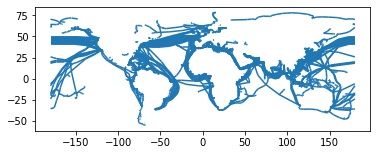

In [69]:
gdf = gpd.GeoDataFrame(gdf, geometry=gdf['line'])
gdf.plot()

In [70]:
gdf = gdf.reset_index( )


In [71]:
gdf.sample(5)

index        lon1       lat1  \
8827  10052   54.000036 -20.574419   
6985   7961  178.087448 -18.453814   
230     267 -131.062384  54.948789   
2497   2867  -65.249880  10.410817   
7564   8624   -7.649920  49.587287   

                                              cable_id  cable_length  \
8827  meltingpot-indianoceanic-submarine-system-metiss        3200.0   
6985                  interchange-cable-network-1-icn1        1259.0   
230             ketchcan1-submarine-fiber-cable-system         167.0   
2497                                venezuelan-festoon        1200.0   
7564                          europe-india-gateway-eig       15000.0   

      cable_capacity  cable_cost        lon2       lat2  \
8827       24.000000       75.00   53.550036 -20.995132   
6985        0.320000       32.00  177.299949 -18.453814   
230        59.198963        4.00 -130.949833  54.754492   
2497        0.104857       62.78  -65.699879  10.410817   
7564        3.840000      700.00   -9.449919  48.704235   

                         fr_point                     to_point       fr_id  \
8827   POINT (54.00004 -20.57442)   POINT (53.55004 -20.99513)   3342562.0   
6985  POINT (178.08745 -18.45381)  POINT (177.29995 -18.45381)  15963364.0   
230   POINT (-131.06238 54.94879)  POINT (-130.94983 54.75449)  -7611359.0   
2497   POINT (-65.24988 10.41082)   POINT (-65.69988 10.41082)  -5483906.0   
7564    POINT (-7.64992 49.58729)    POINT (-9.44992 48.70423)   4193737.0   

           to_id  distance_from_previous  total_distance  \
8827   3255491.0                0.616035       31.444002   
6985  15884614.0                0.787499       10.319225   
230   -7619534.0                0.224542        1.834593   
2497  -5528906.0                0.450000       11.246156   
7564   3925431.0                2.004938      145.421927   

      length_from_previous                                               line  \
8827             62.692749  LINESTRING (54.000035981807684 -20.57441905727...   
6985             96.079091  LINESTRING (178.0874480765248 -18.453813775777...   
230              20.439654  LINESTRING (-131.06238415450144 54.94878902385...   
2497             48.016373  LINESTRING (-65.24987954043327 10.410816505402...   
7564            206.805609  LINESTRING (-7.649920344784732 49.587286740046...   

                                               geometry  
8827  LINESTRING (54.00004 -20.57442, 53.55004 -20.9...  
6985  LINESTRING (178.08745 -18.45381, 177.29995 -18...  
230   LINESTRING (-131.06238 54.94879, -130.94983 54...  
2497  LINESTRING (-65.24988 10.41082, -65.69988 10.4...  
7564  LINESTRING (-7.64992 49.58729, -9.44992 48.70423)

In [72]:
G = nx.from_pandas_edgelist(gdf, 'fr_id', 'to_id', edge_attr=['index', 'length_from_previous'], create_using=nx.Graph)


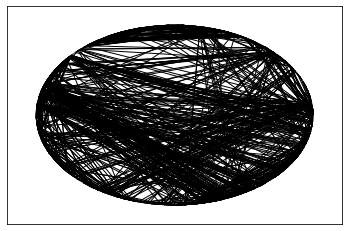

In [73]:
nx.draw_networkx_edges(G, pos=nx.circular_layout(G))


In [74]:
nx.degree_centrality(G)

{5047299.0: 0.00021422450728363326,
 5059775.0: 0.00010711225364181663,
 5067508.0: 0.00010711225364181663,
 282991.0: 0.00021422450728363326,
 535397.0: 0.0006426735218508998,
 170619.0: 0.0003213367609254499,
 4430808.0: 0.00021422450728363326,
 4628380.0: 0.000856898029134533,
 4208301.0: 0.00021422450728363326,
 3880431.0: 0.00021422450728363326,
 2965160.0: 0.00021422450728363326,
 2529840.0: 0.00021422450728363326,
 2228574.0: 0.00021422450728363326,
 2036479.0: 0.00021422450728363326,
 1752613.0: 0.00021422450728363326,
 1466113.0: 0.00021422450728363326,
 1233938.0: 0.00021422450728363326,
 533474.0: 0.00021422450728363326,
 105271.0: 0.00021422450728363326,
 -409876.0: 0.00021422450728363326,
 -716426.0: 0.00021422450728363326,
 -891421.0: 0.00021422450728363326,
 -888501.0: 0.00021422450728363326,
 -888169.0: 0.00021422450728363326,
 -168169.0: 0.00021422450728363326,
 484188.0: 0.00021422450728363326,
 562920.0: 0.00021422450728363326,
 686498.0: 0.00021422450728363326,
 986

In [75]:
# nx.current_flow_closeness_centrality(G,weight='length_from_previous')

In [76]:
path = nx.shortest_path(G,6181995, 4629267, weight = 'length_from_previous')

# def getPath(path, road):
#     pathroad = pd.DataFrame()
#     for i in range(5):
#         # len(path.keys())-1
#         node1 = path[list (path.keys())[i]]
#         print(node1)
#         node2 = path[list (path.keys())[i+1]]
#         print(node2)
#         r = road[(road['fr_id'] == node1) & (road['to_id'] == node2)]
#         pathroad = pathroad.append(r)
#     return pathroad

def getPath(path, road):
    pathroad = pd.DataFrame()
    for i in range(len(path)-1):
        # len(path.keys())-1
        node1 = path[i]
        node2 = path[i+1]
        # fr_id and to_id might be in opposite order
        r = road[ ((road['fr_id'] == node1) & (road['to_id'] == node2)) | (road['fr_id'] == node2) & (road['to_id'] == node1) ]
        pathroad = pathroad.append(r)
    return pathroad

In [77]:
for x in (nx.connected_components(G)):
    print(len(x))

3
6724
287
9
4
466
7
7
220
10
10
4
3
51
7
4
32
9
88
6
33
8
23
3
42
17
28
9
23
9
3
3
5
9
21
3
3
3
3
3
3
3
3
3
3
3
3
4
3
3
9
5
4
4
21
4
14
18
4
6
4
7
16
13
4
9
4
16
6
3
9
4
8
6
38
3
3
3
10
4
38
10
3
3
14
6
4
5
4
5
8
4
4
3
3
130
5
3
15
4
4
4
4
52
3
3
5
4
11
4
5
4
5
3
10
4
3
6
3
6
4
3
3
7
7
3
10
10
4
44
4
5
7
35
6
6
3
4
4
4
7
5
3
4
4
4
18
7
9
8
4
5
4
3
4
3
6
7
9
7
7
6
12
4
5
3
13
12
3
14
10
5
18
4
4
3
5
5
4


## Centrality

In [78]:
# getPath(max(nx.connected_components(G), key=len),gdf).plot()
raw_centrality = gdf[gdf['fr_id'].isin(max(nx.connected_components(G), key=len))]


In [79]:
raw_centrality['centrality'] = raw_centrality['fr_id'].map(nx.degree_centrality(G))
raw_centrality.to_csv('/Users/dijiongyuequ/Downloads/cable_centrality_length.csv')


/opt/homebrew/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [80]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    country_centrality = pd.read_sql("select sum(centrality) as country_centrality, CountryName, CapitalLongitude as capital_lon, CapitalLatitude as capital_lat, CountryCode, ContinentName from cable_centrality_length join landing_points lp on round(lon1,3) = round(landingPoint_longitude,3) and round(lat1,3) = round(landingPoint_latitude,3) left join world_countries wc on lp.landingPoint_country=wc.name left join Country_capital cc on wc.code=cc.CountryCode where CapitalName is not null group by CountryCode order by country_centrality desc",con=con)
country_centrality.head(10)

country_centrality           CountryName  capital_lon  capital_lat  \
0            0.463484                 India    77.200000    28.600000   
1            0.432545             Singapore   103.850000     1.283333   
2            0.369627                 Japan   139.750000    35.683333   
3            0.228916          Saudi Arabia    46.700000    24.650000   
4            0.216421                Brazil   -47.916667   -15.783333   
5            0.194556         United States   -77.000000    38.883333   
6            0.190540                France     2.333333    48.866667   
7            0.162576             Indonesia   106.816667    -6.166667   
8            0.156180  United Arab Emirates    54.366667    24.466667   
9            0.089395              Pakistan    73.050000    33.683333   

  CountryCode    ContinentName  
0          IN             Asia  
1          SG             Asia  
2          JP             Asia  
3          SA             Asia  
4          BR    South America  
5          US  Central America  
6          FR           Europe  
7          ID             Asia  
8          AE             Asia  
9          PK             Asia

In [81]:
world_map = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2)
country_centrality["country_centrality"]=country_centrality["country_centrality"]*100
lon=country_centrality["capital_lon"]
lat=country_centrality["capital_lat"]
num=country_centrality.shape[0]
for i in range(num):
    folium.CircleMarker(radius=float(country_centrality["country_centrality"][i]),location=[lat[i],lon[i]],color="crimson",fill=True,fill_color="crimson",fill_opacity=0.7).add_to(world_map)
world_map

In [82]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    landingPoint_centrality = pd.read_sql("select landingPoint_name,landingPoint_id,landingPoint_country, landingPoint_longitude,landingPoint_latitude, sum(centrality)as landingPoint_centrality from cable_centrality_length join landing_points lp on round(lon1,3) = round(landingPoint_longitude,3) and round(lat1,3) = round(landingPoint_latitude,3) group by landingPoint_id order by landingPoint_centrality desc",con=con)
landingPoint_centrality.head(10)


landingPoint_name                landingPoint_id  \
0                   Mumbai, India                   mumbai-india   
1                    Shima, Japan                    shima-japan   
2            Jeddah, Saudi Arabia            jeddah-saudi-arabia   
3               Marseille, France               marseille-france   
4         Changi North, Singapore         changi-north-singapore   
5                 Tuas, Singapore                 tuas-singapore   
6  Fujairah, United Arab Emirates  fujairah-united-arab-emirates   
7               Fortaleza, Brazil               fortaleza-brazil   
8         Piti, GU, United States          piti-gu-united-states   
9         Changi South, Singapore         changi-south-singapore   

   landingPoint_country  landingPoint_longitude  landingPoint_latitude  \
0                 India               72.875866              19.076080   
1                 Japan              136.874281              34.336890   
2          Saudi Arabia               39.182863              21.481547   
3                France                5.372507              43.293579   
4             Singapore              103.987012               1.389045   
5             Singapore              103.646210               1.338646   
6  United Arab Emirates               56.333726              25.121693   
7                Brazil              -38.542965              -3.718834   
8         United States              144.694742              13.464655   
9             Singapore              103.987012               1.389045   

   landingPoint_centrality  
0                 0.428380  
1                 0.252863  
2                 0.208835  
3                 0.189499  
4                 0.171352  
5                 0.162427  
6                 0.154693  
7                 0.148743  
8                 0.111260  
9                 0.095196

In [83]:
world_map = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2.5)
landingPoint_centrality_value=landingPoint_centrality["landingPoint_centrality"]*65
lon=landingPoint_centrality["landingPoint_longitude"]
lat=landingPoint_centrality["landingPoint_latitude"]
num=landingPoint_centrality.shape[0]
for i in range(num):
    folium.CircleMarker(radius=float(landingPoint_centrality_value[i]),location=[lat[i],lon[i]],color="crimson",fill=True,fill_color="crimson",fill_opacity=0.7).add_to(world_map)
world_map

In [84]:
world_map = folium.Map()
heatdata = landingPoint_centrality[['landingPoint_latitude','landingPoint_longitude']].values.tolist()

HeatMap(heatdata,radius=15).add_to(world_map)



neighborCount=landingPoint_centrality["landingPoint_centrality"]*65
lon=landingPoint_centrality["landingPoint_longitude"]
lat=landingPoint_centrality["landingPoint_latitude"]
num=neighborCount.shape[0]
for i in range(num):
    folium.CircleMarker(radius=float(neighborCount[i]),location=[lat[i],lon[i]],stroke=3,color="crimson",fill=True,fill_color="crimson",fill_opacity=0.7).add_to(world_map)


world_map

In [85]:
raw_centrality['inverse_capacity'] = 1/raw_centrality['cable_capacity']
G2 = nx.from_pandas_edgelist(raw_centrality, 'fr_id', 'to_id', edge_attr=['index', 'length_from_previous','cable_capacity', 'inverse_capacity','cable_cost'], create_using=nx.Graph)

nx.algorithms.efficiency(G2,6158154, 4629267)



/opt/homebrew/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


0.029411764705882353

/opt/homebrew/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:>

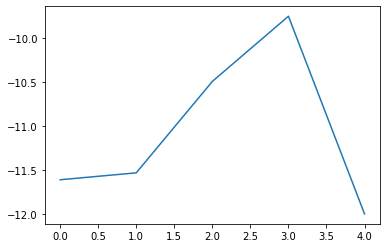

In [86]:
dict_rickClub = nx.algorithms.rich_club_coefficient(G2,normalized=False)
df_rickClub = pd.DataFrame(dict_rickClub.values(),columns=['rich_club_coefficient'])
df_rickClub['log(rich_club)'] = np.log2(df_rickClub['rich_club_coefficient'])
df_rickClub['log(rich_club)'].plot()

In [87]:
df_rickClub

rich_club_coefficient  log(rich_club)
0                0.000320      -11.611611
1                0.000337      -11.533138
2                0.000693      -10.495099
3                0.001157       -9.754967
4                0.000244      -11.999648
5                0.000000            -inf
6                0.000000            -inf
7                0.000000            -inf
8                0.000000            -inf
9                0.000000            -inf
10               0.000000            -inf
11               0.000000            -inf
12               0.000000            -inf
13               0.000000            -inf
14               0.000000            -inf
15               0.000000            -inf
16               0.000000            -inf
17               0.000000            -inf

# Betweenness centrality

In [88]:
worldMap = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
worldMap.loc[worldMap['name'] == 'France', 'iso_a3'] = 'FRA'
worldMap.loc[worldMap['name'] == 'Norway', 'iso_a3'] = 'NOR'
worldMap.loc[worldMap['name'] == 'N. Cyprus', 'iso_a3'] = 'CYP'
worldMap.loc[worldMap['name'] == 'Somaliland', 'iso_a3'] = 'SOM'
worldMap.loc[worldMap['name'] == 'Kosovo', 'iso_a3'] = 'RKS'

In [89]:
# raw_centrality.
dict_betweennessCentrality_length = nx.algorithms.betweenness_centrality(G2,weight='length_from_previous')
df_betweennessCentrality_length = pd.DataFrame({'betCentralityId': dict_betweennessCentrality_length.keys(), 'betCentralityValue': dict_betweennessCentrality_length.values()}).sort_values(by=['betCentralityValue'])



In [90]:
df_length_betweennessCentrality = raw_centrality.merge(right=df_betweennessCentrality_length, how='inner',left_on='fr_id', right_on='betCentralityId').sort_values(by=['betCentralityValue'])


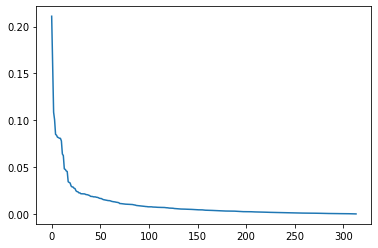

In [91]:
df_length_cable_betweennessCentrality = df_length_betweennessCentrality.groupby(['cable_id'],as_index=False).agg({'betCentralityValue':'mean'}).sort_values(by='betCentralityValue',ascending=False).reset_index(drop=True)
plt.plot(df_length_cable_betweennessCentrality['betCentralityValue'])


Text(0.5, 1.0, 'Betweenness centrality(Latency first)')

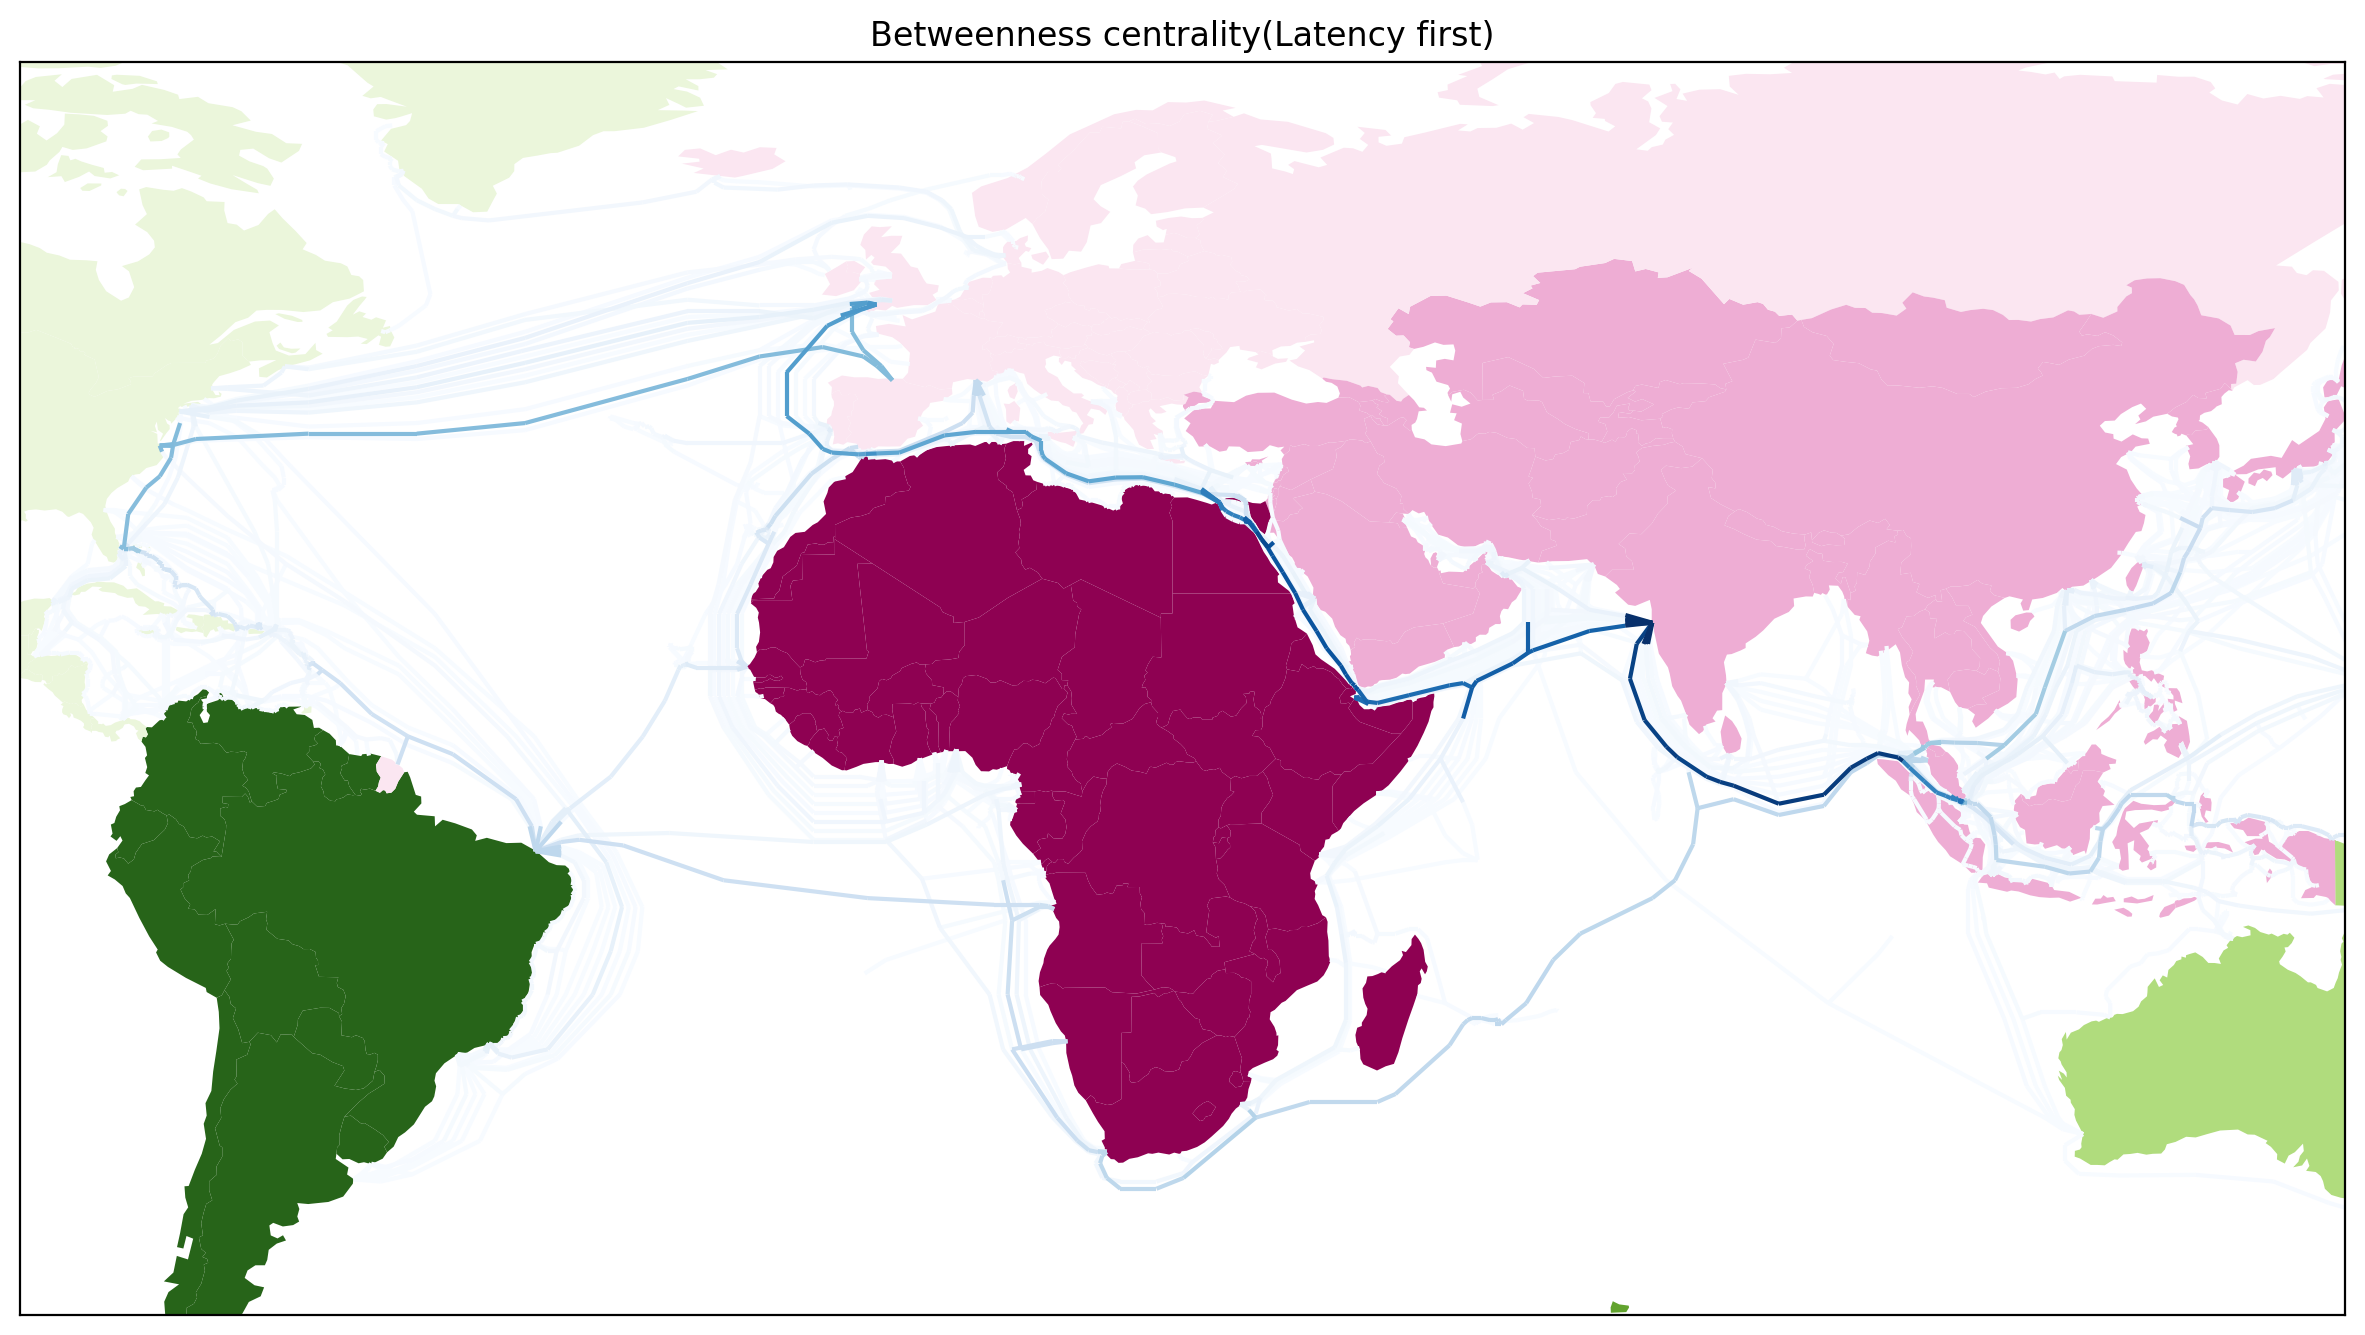

In [92]:
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
orig_Blues=plt.cm.get_cmap('Blues')
worldMap.plot(column = 'continent', ax=ax, cmap = 'PiYG')
df_length_betweennessCentrality.plot(column = 'betCentralityValue',ax=ax,cmap=orig_Blues)

ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.xlim([-90,142])
plt.ylim([-50,75])
plt.title("Betweenness centrality(Latency first)")


In [93]:
dict_betweennessCentrality_capacity = nx.algorithms.betweenness_centrality(G2,weight='cable_capacity')
df_betweennessCentrality_capacity = pd.DataFrame({'betCentralityId': dict_betweennessCentrality_capacity.keys(), 'betCentralityValue': dict_betweennessCentrality_capacity.values()}).sort_values(by=['betCentralityValue'])



In [94]:
df_capacity_betweennessCentrality = raw_centrality.merge(right=df_betweennessCentrality_capacity, how='inner',left_on='fr_id', right_on='betCentralityId').sort_values(by=['betCentralityValue'])


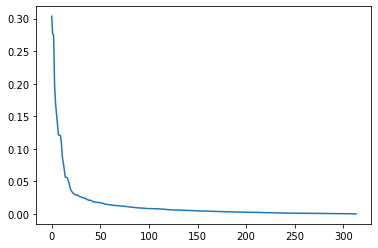

In [95]:
df_capacity_cable_betweennessCentrality = df_capacity_betweennessCentrality.groupby(['cable_id'],as_index=False).agg({'betCentralityValue':'mean'}).sort_values(by='betCentralityValue',ascending=False).reset_index(drop=True)
plt.plot(df_capacity_cable_betweennessCentrality['betCentralityValue'])


Text(0.5, 1.0, 'Betweenness centrality(Small capacity first)')

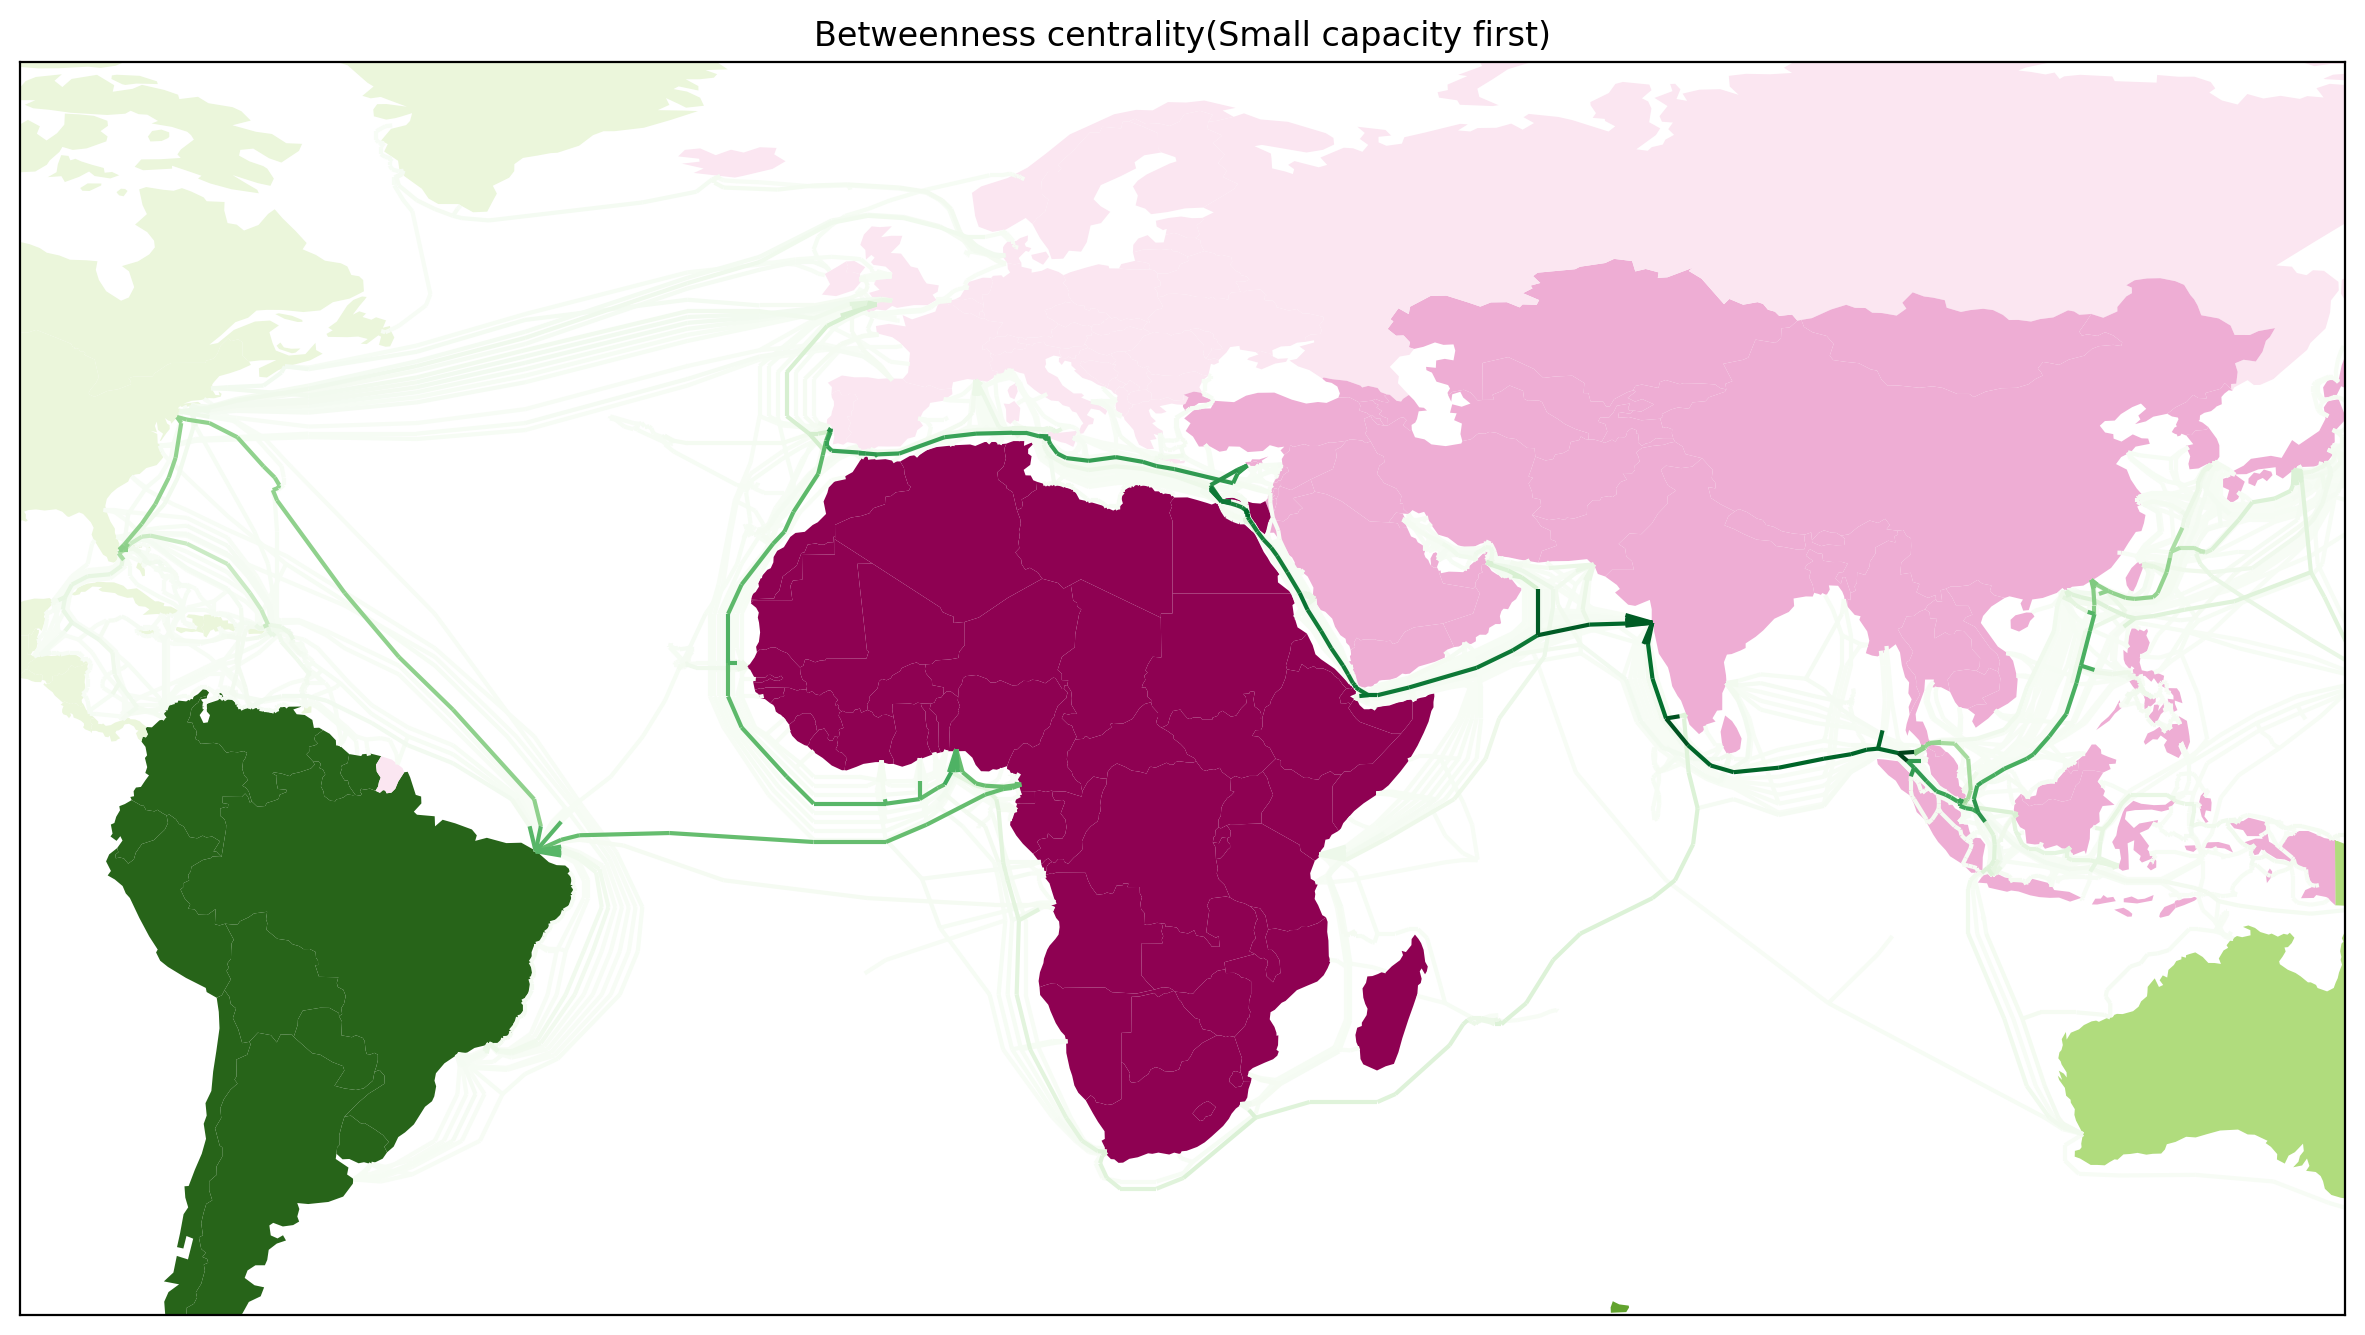

In [96]:
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
worldMap.plot(column = 'continent', ax=ax, cmap = 'PiYG')
orig_Greens=plt.cm.get_cmap('Greens')
df_capacity_betweennessCentrality.plot(column = 'betCentralityValue',ax=ax,cmap=orig_Greens)

ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.xlim([-90,142])
plt.ylim([-50,75])
plt.title("Betweenness centrality(Small capacity first)")


In [97]:
# raw_centrality.
dict_betweennessCentrality_cost = nx.algorithms.betweenness_centrality(G2,weight='cable_cost')
df_betweennessCentrality_cost = pd.DataFrame({'betCentralityId': dict_betweennessCentrality_cost.keys(), 'betCentralityValue': dict_betweennessCentrality_cost.values()}).sort_values(by=['betCentralityValue'])



In [98]:
df_cost_betweennessCentrality =raw_centrality.merge(right=df_betweennessCentrality_cost, how='inner',left_on='fr_id', right_on='betCentralityId').sort_values(by=['betCentralityValue'])


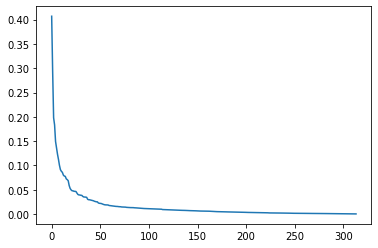

In [99]:
df_cost_cable_betweennessCentrality = df_cost_betweennessCentrality.groupby(['cable_id'],as_index=False).agg({'betCentralityValue':'mean'}).sort_values(by='betCentralityValue',ascending=False).reset_index(drop=True)
plt.plot(df_cost_cable_betweennessCentrality['betCentralityValue'])


Text(0.5, 1.0, 'Betweenness centrality(Cost first)')

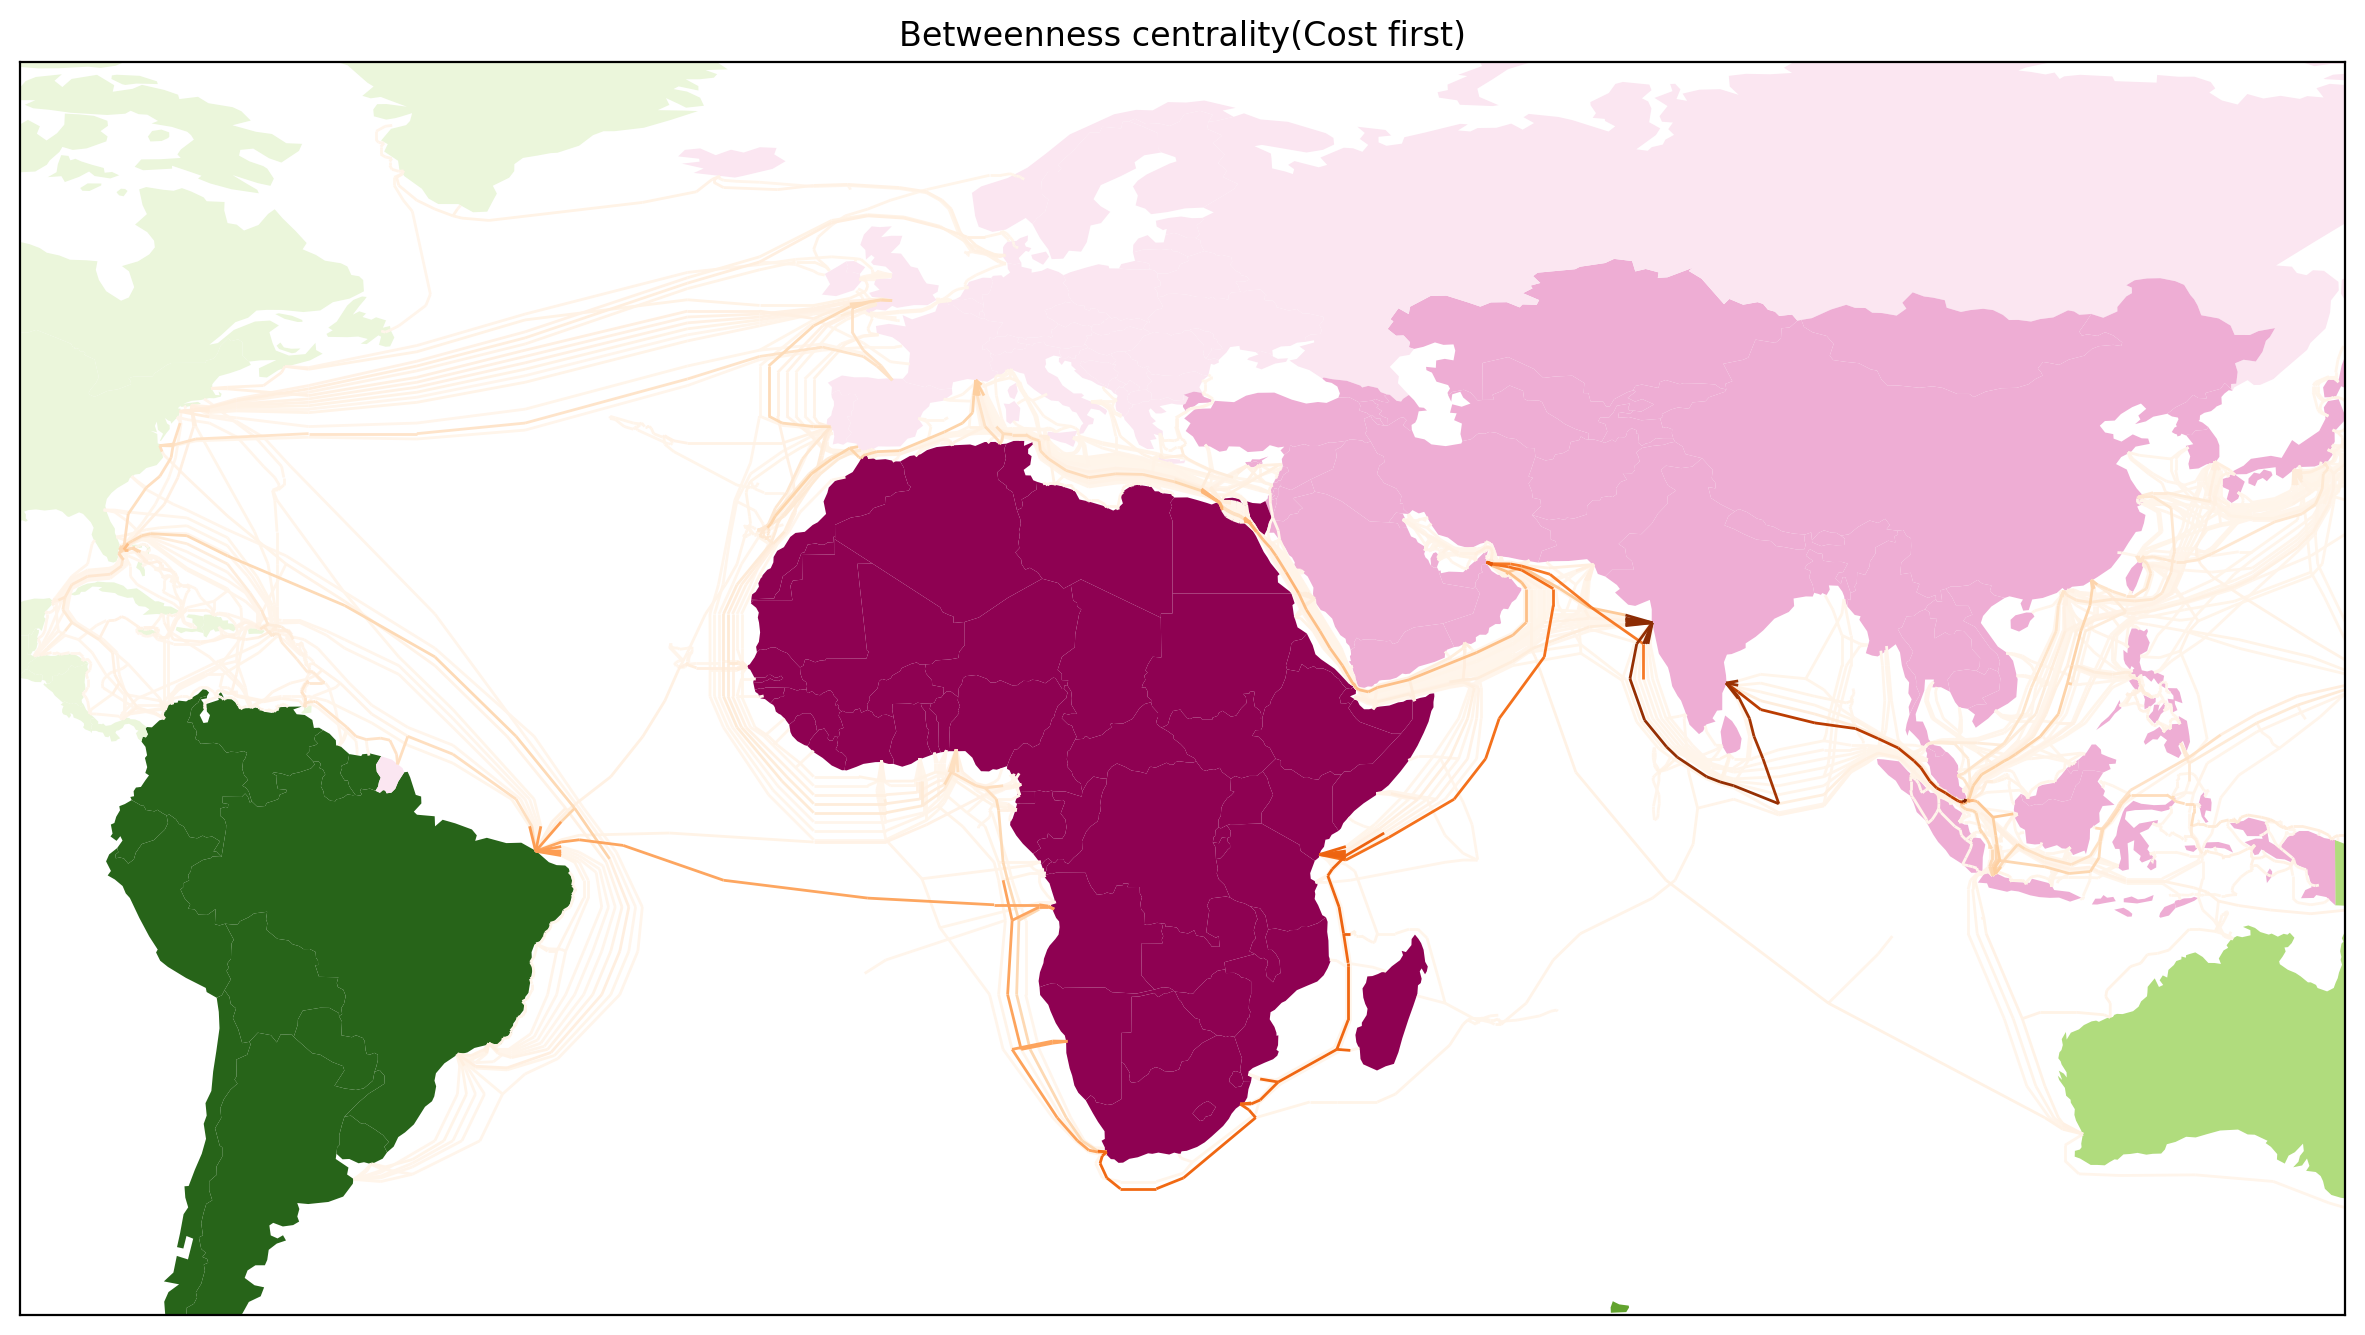

In [100]:
# df_betweennessCentrality_cost = df_betweennessCentrality_cost.sort_values(by=['betCentralityValue']).reset_index()
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
worldMap.plot(column = 'continent', ax=ax, cmap = 'PiYG')
orig_Oranges=plt.cm.get_cmap('Oranges')
df_cost_betweennessCentrality.plot(column = 'betCentralityValue',ax=ax,cmap=orig_Oranges,linewidth=1)

ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.xlim([-90,142])
plt.ylim([-50,75])
plt.title("Betweenness centrality(Cost first)")


In [101]:
# raw_centrality.
dict_betweennessCentrality_inverseCapacity = nx.algorithms.betweenness_centrality(G2,weight='inverse_capacity')
df_betweennessCentrality_inverseCapacity = pd.DataFrame({'betCentralityId': dict_betweennessCentrality_inverseCapacity.keys(), 'betCentralityValue': dict_betweennessCentrality_inverseCapacity.values()}).sort_values(by=['betCentralityValue'])



In [102]:
df_inverseCap_betweennessCentrality = raw_centrality.merge(right=df_betweennessCentrality_inverseCapacity, how='inner',left_on='fr_id', right_on='betCentralityId').sort_values(by=['betCentralityValue'])


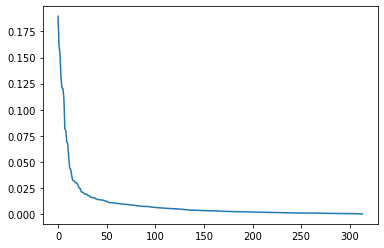

In [103]:
df_inverseCap_cable_betweennessCentrality = df_inverseCap_betweennessCentrality.groupby(['cable_id'],as_index=False).agg({'betCentralityValue':'mean'}).sort_values(by='betCentralityValue',ascending=False).reset_index(drop=True)
plt.plot(df_inverseCap_cable_betweennessCentrality['betCentralityValue'])


Text(0.5, 1.0, 'Betweenness centrality(Capacity first)')

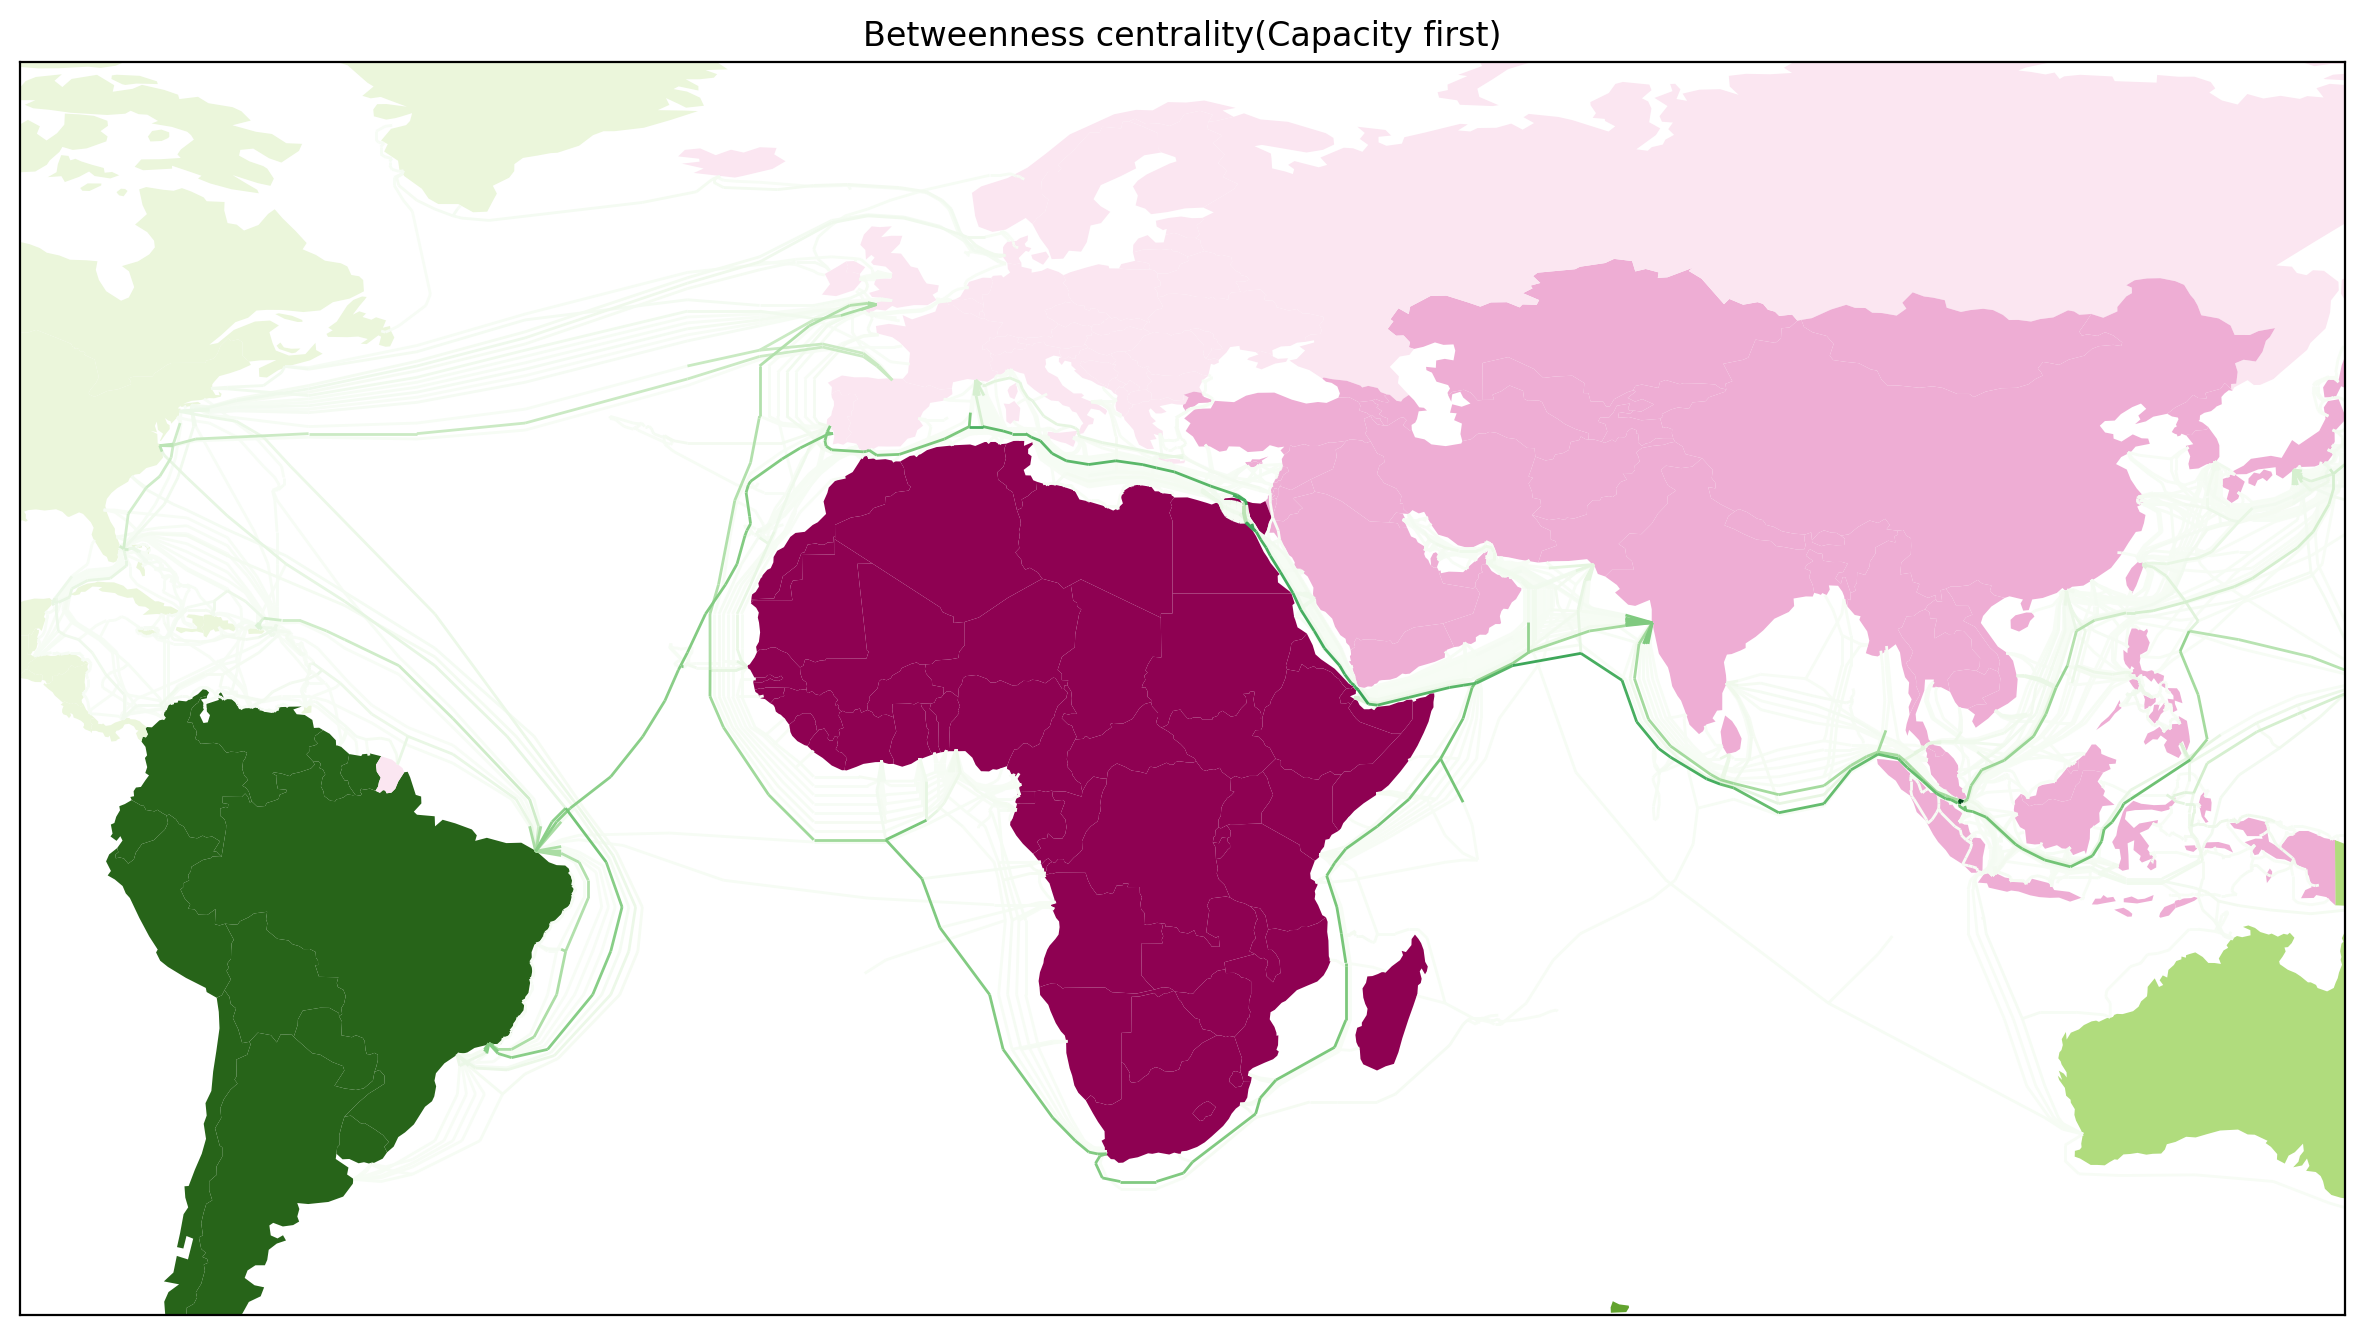

In [104]:
# df_betweennessCentrality_cost = df_betweennessCentrality_cost.sort_values(by=['betCentralityValue']).reset_index()
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
worldMap.plot(column = 'continent', ax=ax, cmap = 'PiYG')
orig_Greens=plt.cm.get_cmap('Greens')
df_inverseCap_betweennessCentrality.plot(column = 'betCentralityValue',ax=ax,cmap=orig_Greens,linewidth=1)

ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.xlim([-90,142])
plt.ylim([-50,75])
plt.title("Betweenness centrality(Capacity first)")


Text(0.5, 1.0, 'Cable betweenness centrality')

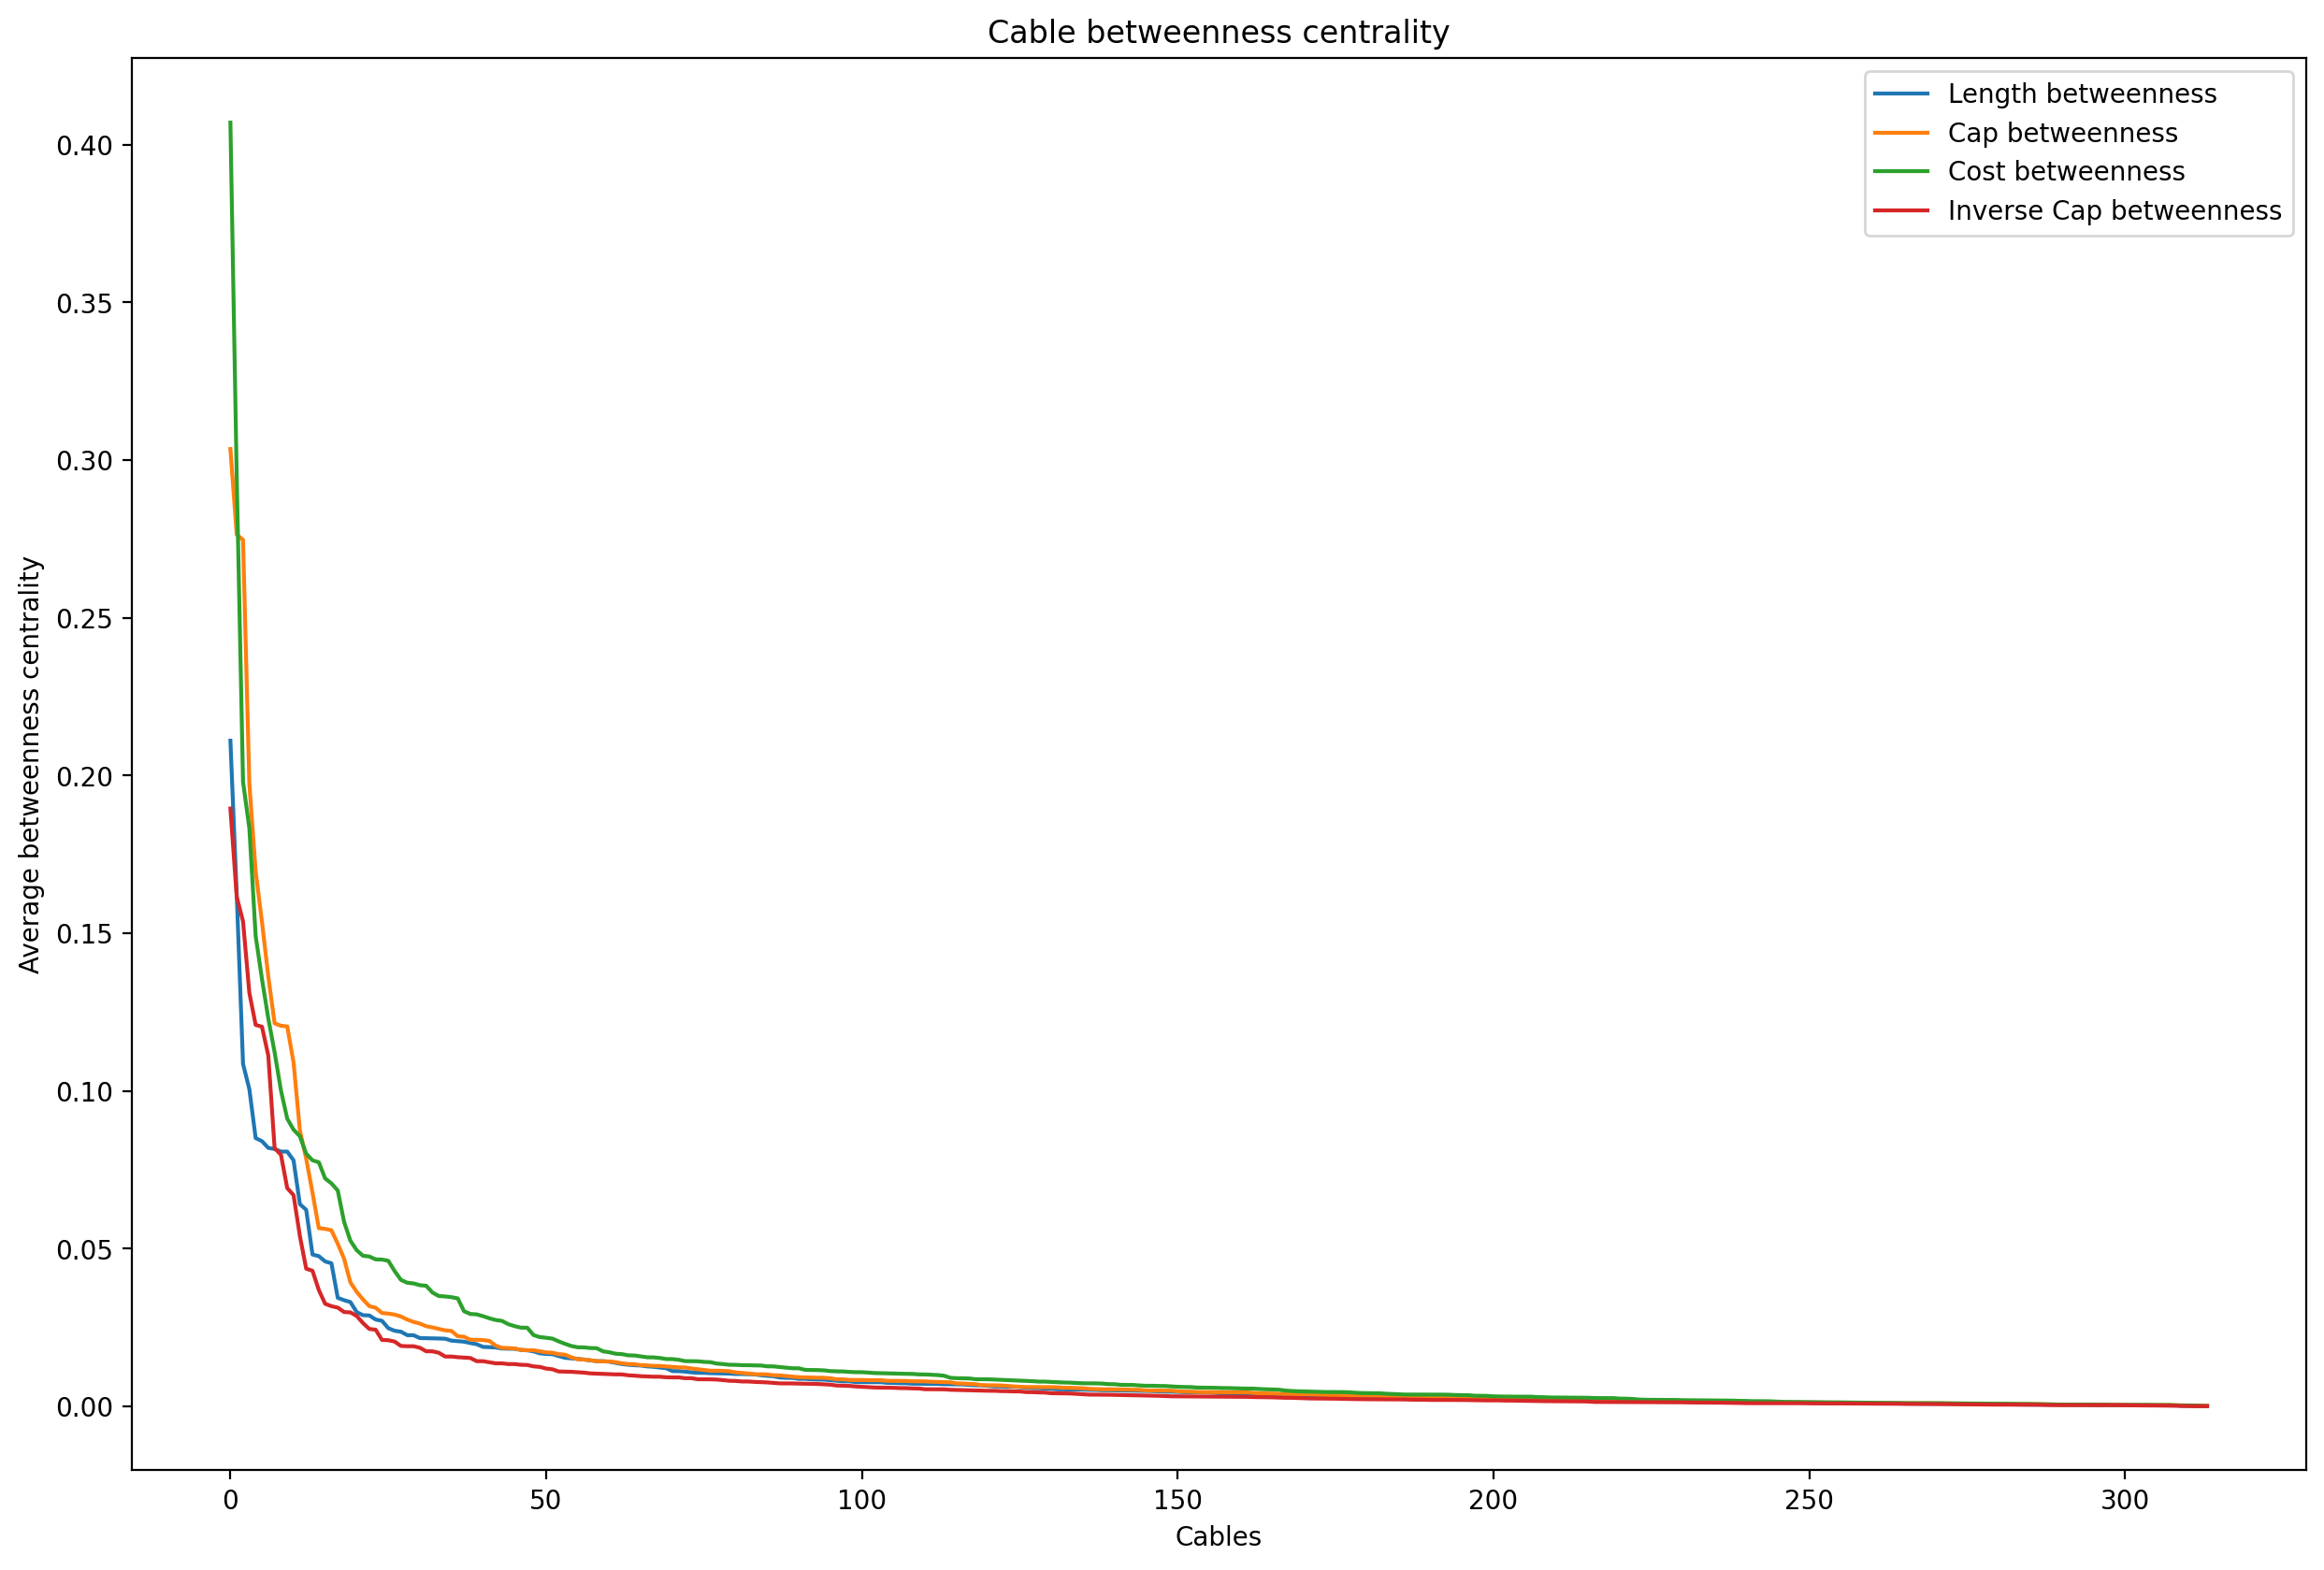

In [159]:
# 对于电缆的between分析
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
plt.plot(df_length_cable_betweennessCentrality['betCentralityValue'],label='Length betweenness')
plt.plot(df_capacity_cable_betweennessCentrality['betCentralityValue'],label='Cap betweenness')
plt.plot(df_cost_cable_betweennessCentrality['betCentralityValue'],label='Cost betweenness')
plt.plot(df_inverseCap_cable_betweennessCentrality['betCentralityValue'],label='Inverse Cap betweenness')
plt.legend()
plt.xlabel('Cables')
plt.ylabel('Average betweenness centrality')
plt.title('Cable betweenness centrality')

Text(0.5, 1.0, 'Node betweenness centrality')

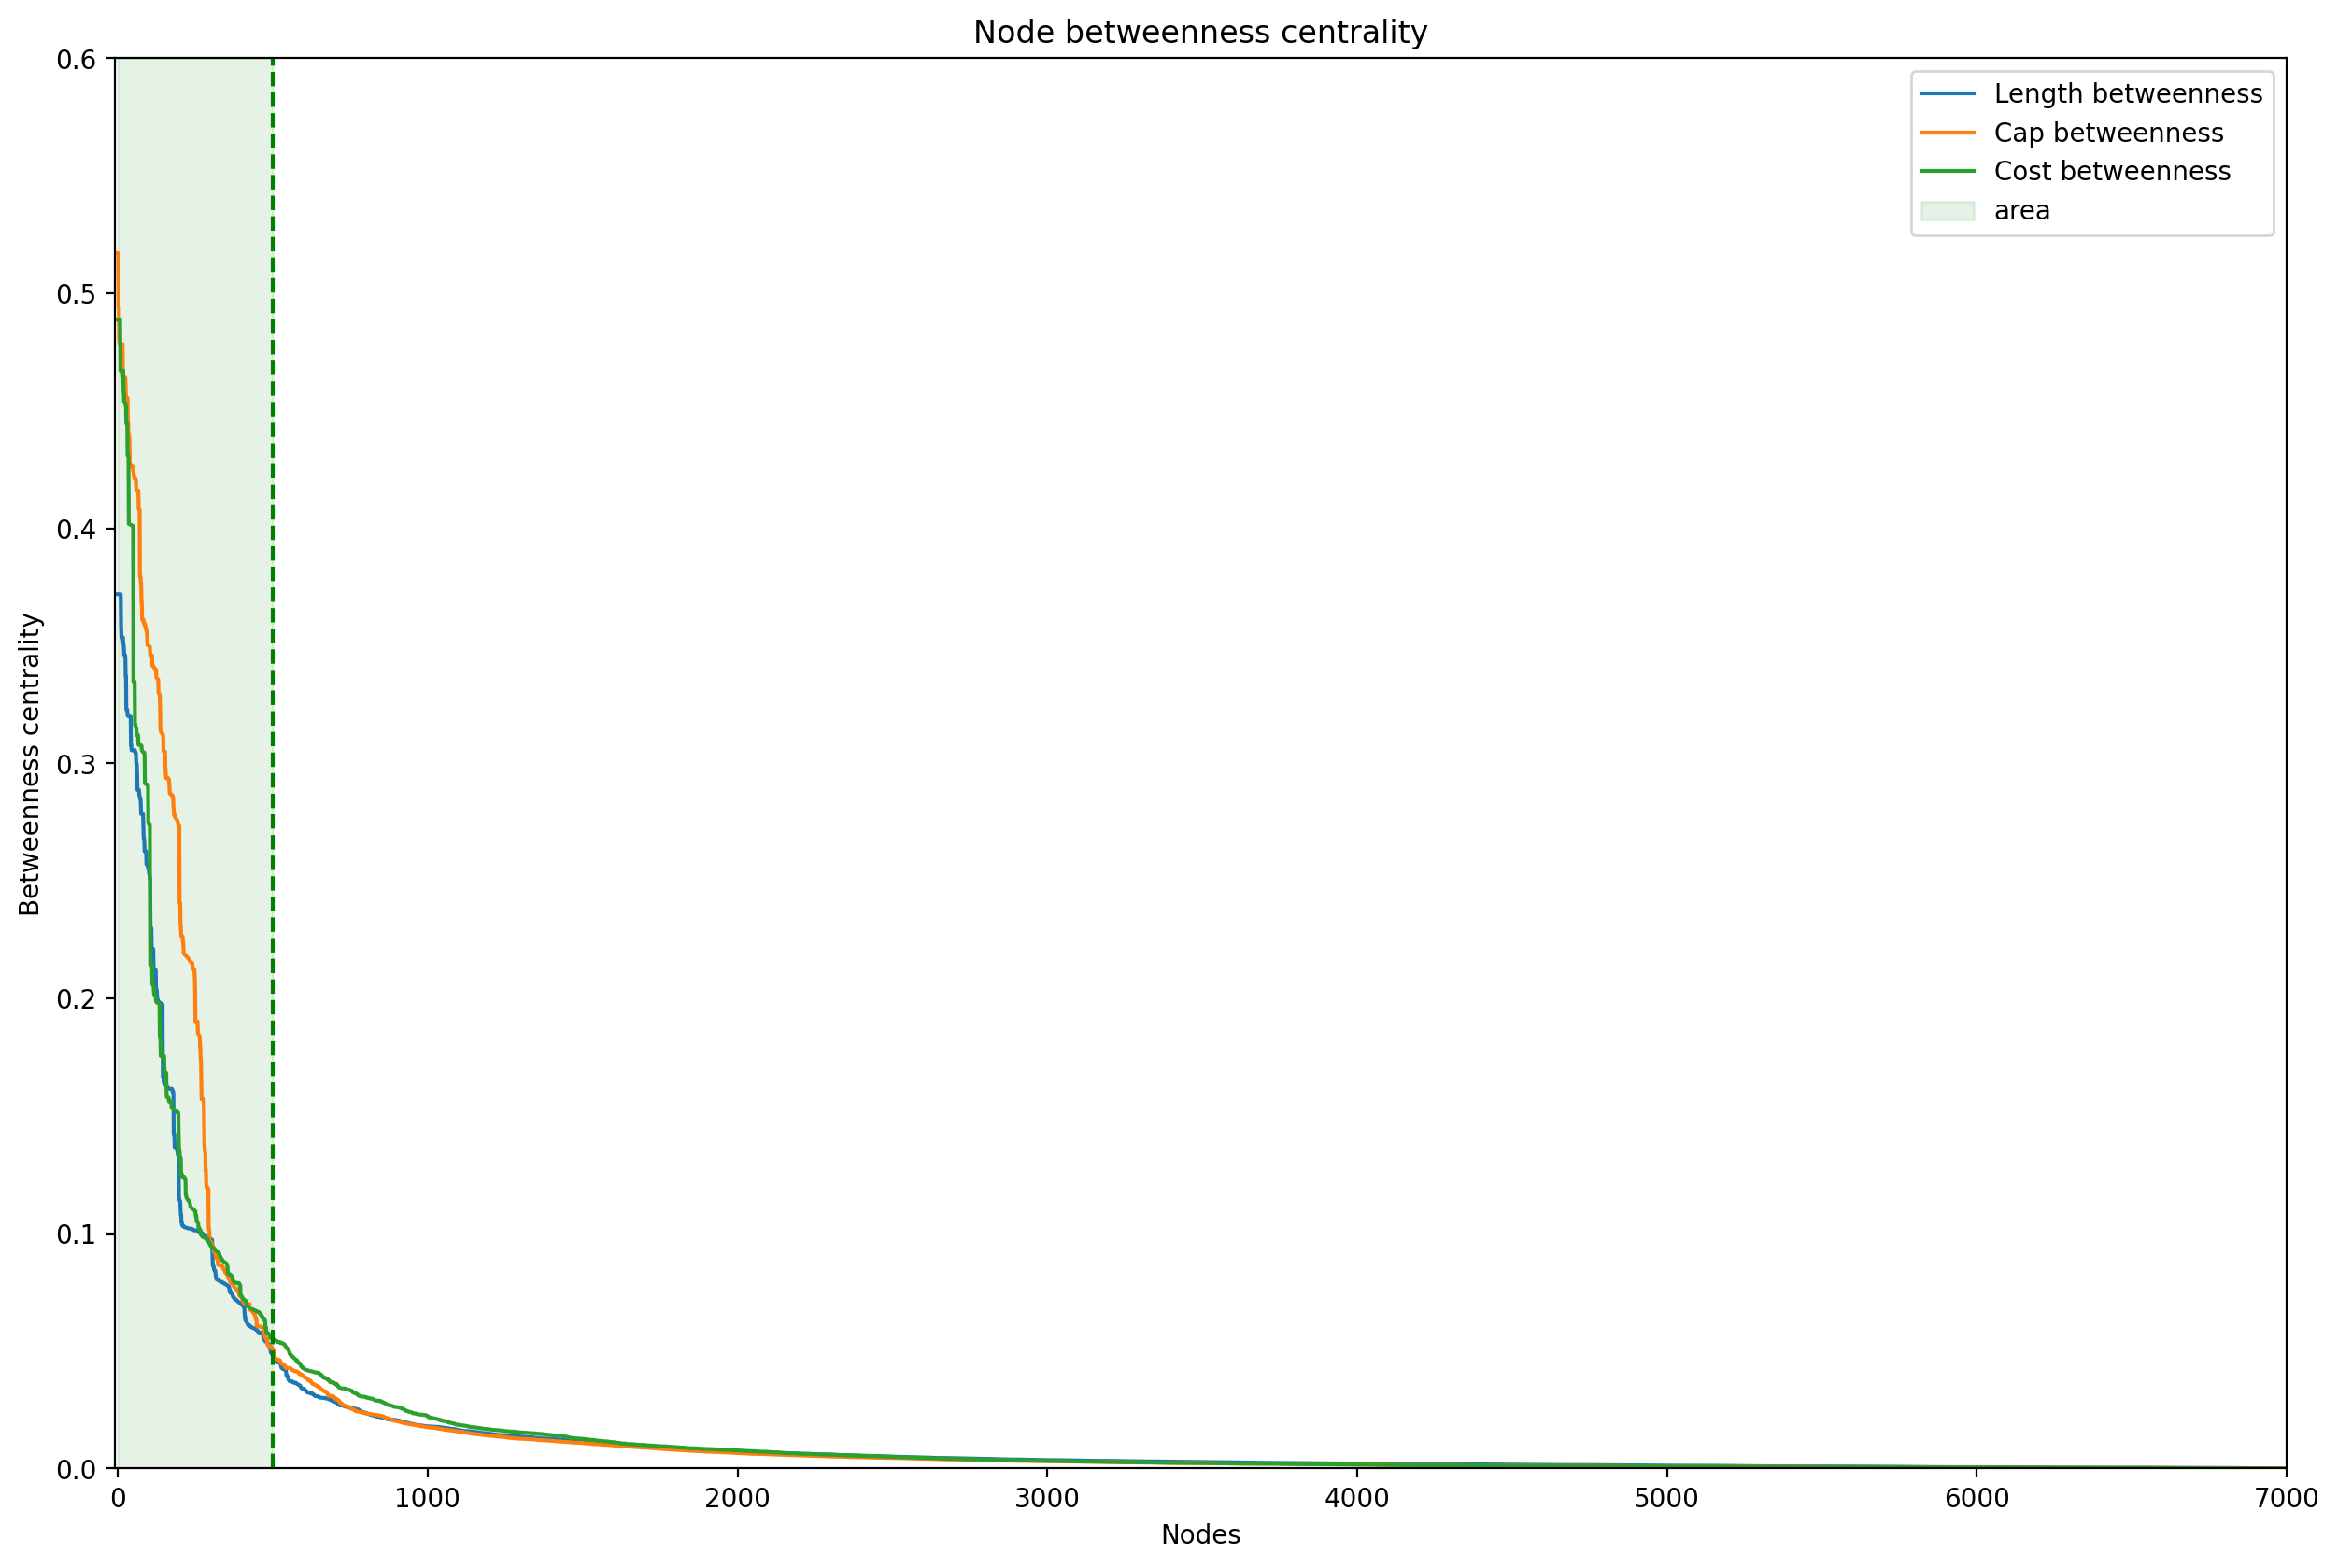

In [181]:
# 对于点的
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
plt.plot(df_length_betweennessCentrality['betCentralityValue'].sort_values(ascending=False).reset_index(drop=True),label='Length betweenness')
plt.plot(df_capacity_betweennessCentrality['betCentralityValue'].sort_values(ascending=False).reset_index(drop=True),label='Cap betweenness')
plt.plot(df_cost_betweennessCentrality['betCentralityValue'].sort_values(ascending=False).reset_index(drop=True),label='Cost betweenness')
# plt.plot(df_inverseCap_betweennessCentrality['betCentralityValue'].sort_values(ascending=False).reset_index(drop=True),label='Inverse Cap betweenness')
ax.vlines(500,0,0.6,colors = "g",linestyles = "dashed")
ax.axvspan(xmin=0,xmax=500,color = "g", alpha = 0.1,label='area')

plt.legend()
plt.xlabel('Nodes')
plt.ylabel('Betweenness centrality')
plt.xlim(-10,7000)
plt.ylim(0,0.6)
plt.title('Node betweenness centrality')

Text(0.5, 1.0, 'Betweenness centrality(zoomed)')

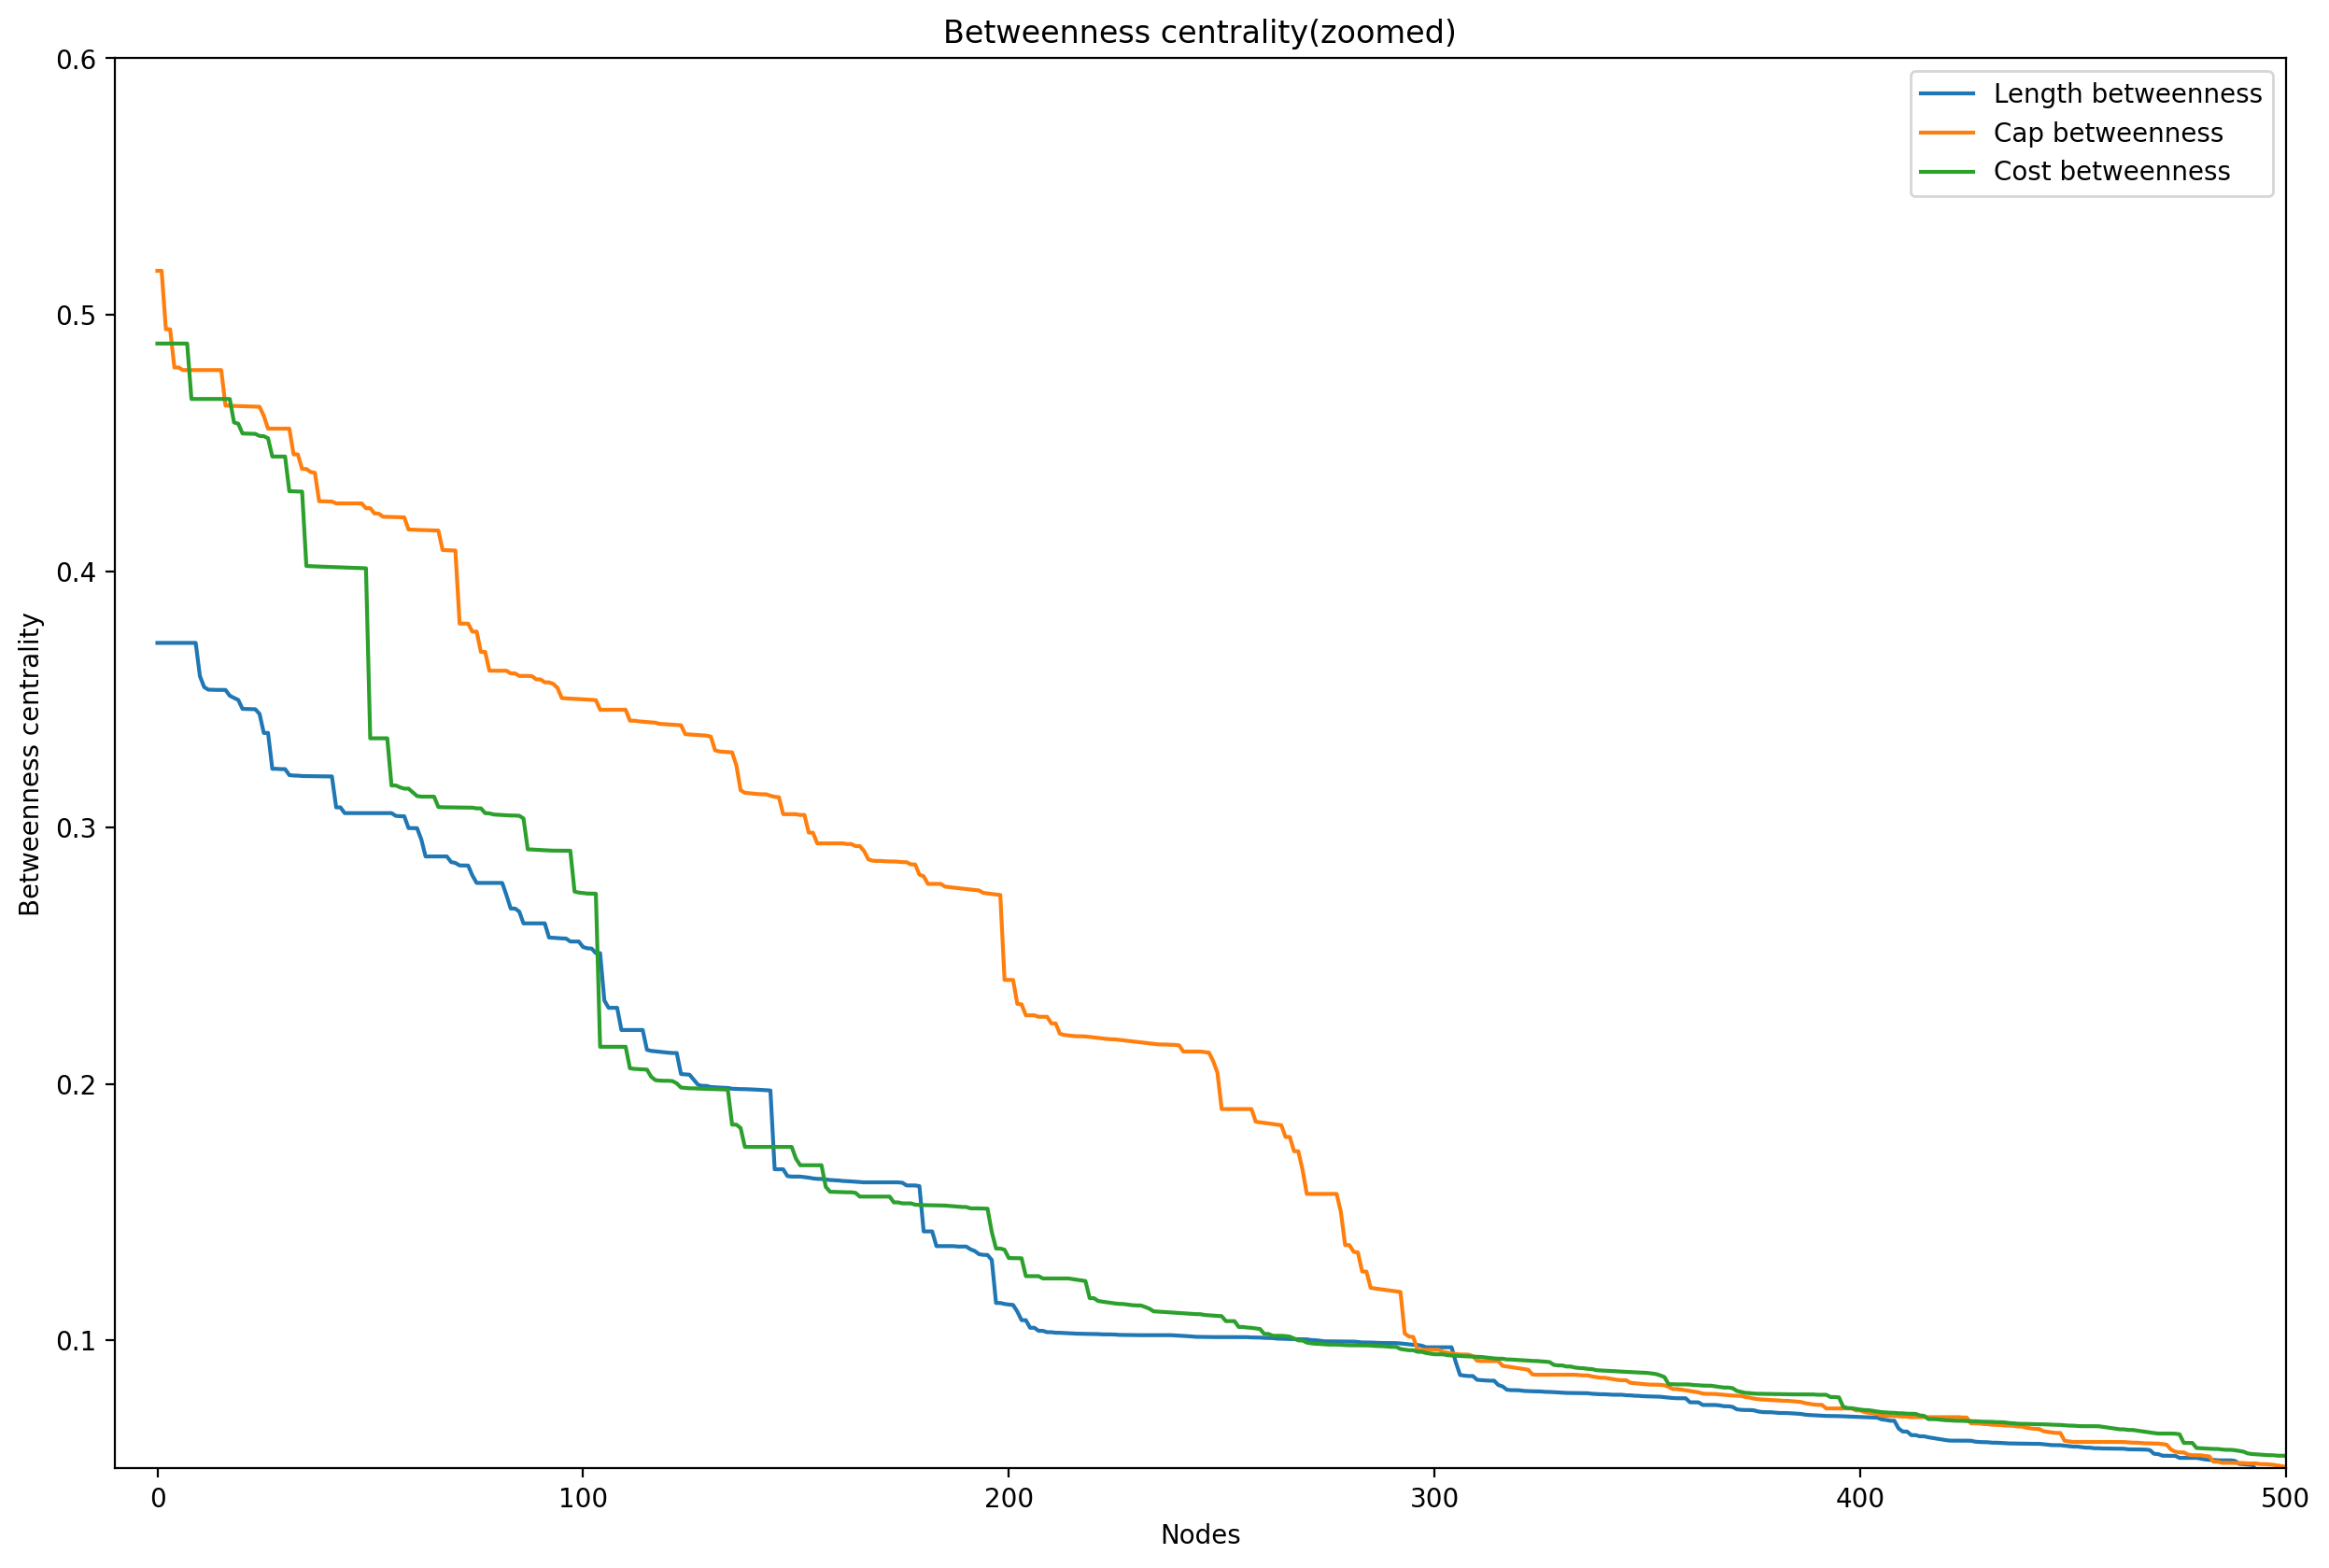

In [161]:
# 对于点, 细节
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
plt.plot(df_length_betweennessCentrality['betCentralityValue'].sort_values(ascending=False).reset_index(drop=True),label='Length betweenness')
plt.plot(df_capacity_betweennessCentrality['betCentralityValue'].sort_values(ascending=False).reset_index(drop=True),label='Cap betweenness')
plt.plot(df_cost_betweennessCentrality['betCentralityValue'].sort_values(ascending=False).reset_index(drop=True),label='Cost betweenness')
# plt.plot(df_inverseCap_betweennessCentrality['betCentralityValue'].sort_values(ascending=False).reset_index(drop=True),label='Inverse Cap betweenness')
plt.legend()
plt.xlabel('Nodes')
plt.ylabel('Betweenness centrality')
plt.xlim(-10,500)
plt.ylim(0.05,0.6)
plt.title('Betweenness centrality(zoomed)')

Text(0.5, 1.0, 'Betweenness centrality(Aggregated)')

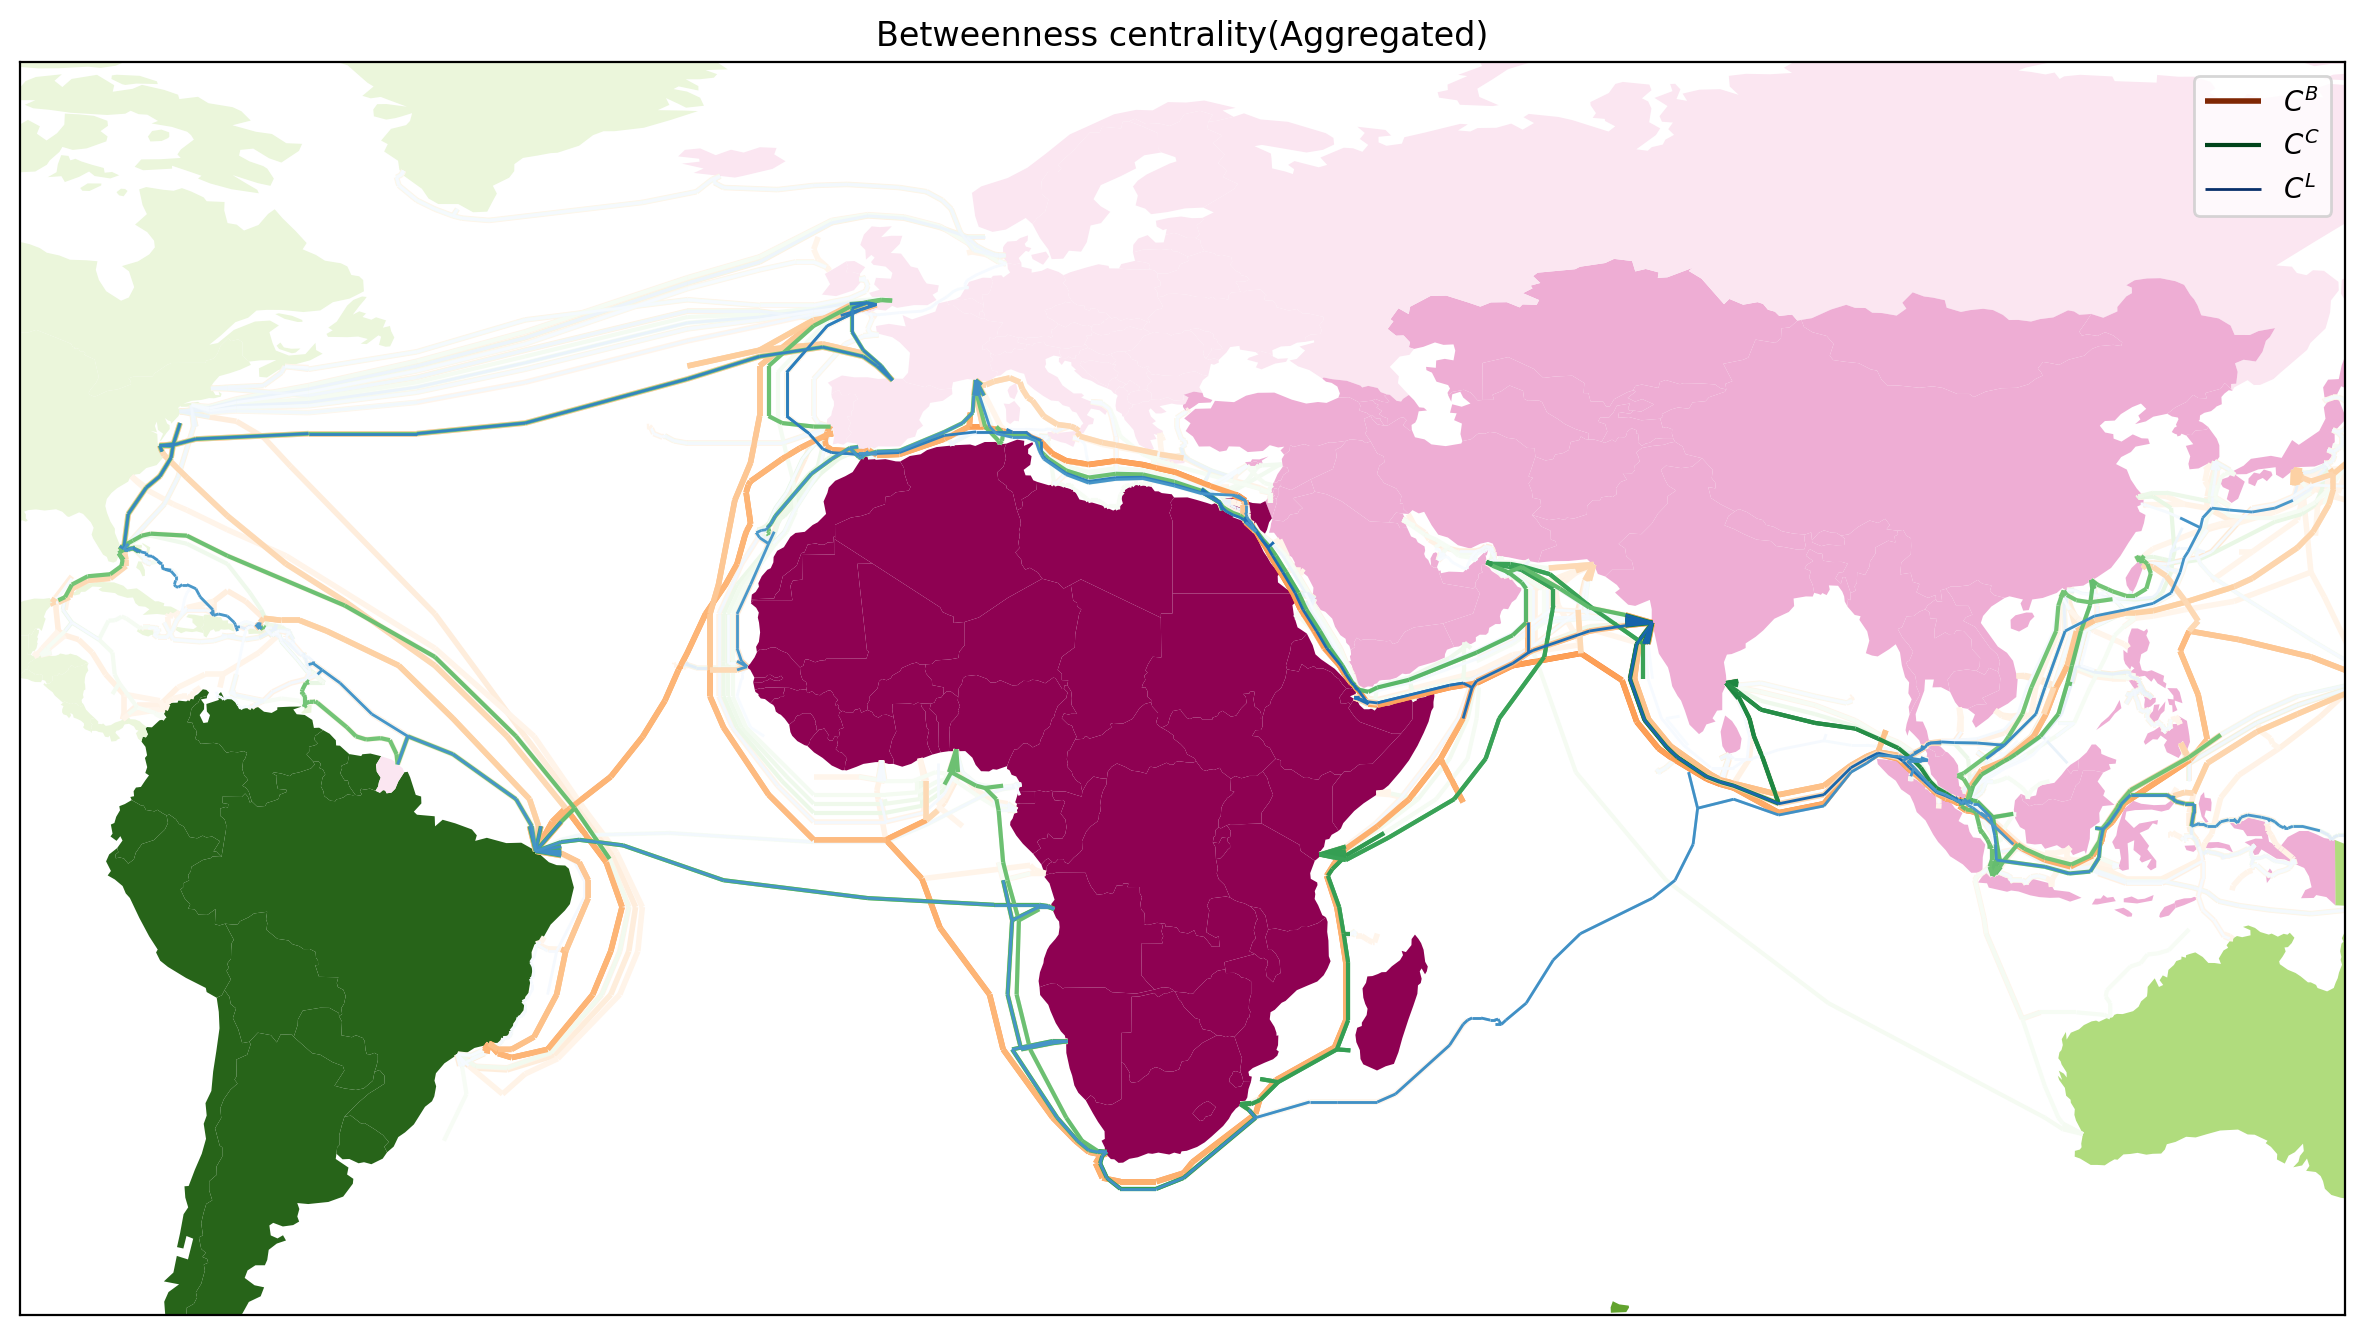

In [105]:
fig     = plt.figure(figsize=(15,10),dpi = 200)
ax      = plt.subplot(111)
worldMap.plot(column = 'continent', ax=ax, cmap = 'PiYG')
df_inverseCap_betweennessCentrality.sort_values(by=['betCentralityValue'],ascending=False).head(2200).plot(column = 'betCentralityValue',ax=ax,cmap=orig_Oranges,linewidth=2, label = f'$C^B$')
df_cost_betweennessCentrality.sort_values(by=['betCentralityValue'],ascending=False).head(2200).plot(column = 'betCentralityValue',ax=ax,cmap=orig_Greens,linewidth=1.5, label = f'$C^C$')
df_length_betweennessCentrality.sort_values(by=['betCentralityValue'],ascending=False).head(2200).plot(column = 'betCentralityValue',ax=ax,cmap=orig_Blues,linewidth=1, label = f'$C^L$')

df_inverseCap_betweennessCentrality.sort_values(by=['betCentralityValue'],ascending=False).head(500).plot(column = 'betCentralityValue',ax=ax,cmap=cmr.get_sub_cmap('Oranges', 0.2,0.6,N=20),linewidth=2)
df_cost_betweennessCentrality.sort_values(by=['betCentralityValue'],ascending=False).head(500).plot(column = 'betCentralityValue',ax=ax,cmap=cmr.get_sub_cmap('Greens', 0.5,0.8,N=20),linewidth=1.5)
df_length_betweennessCentrality.sort_values(by=['betCentralityValue'],ascending=False).head(500).plot(column = 'betCentralityValue',ax=ax,cmap=cmr.get_sub_cmap('Blues', 0.6,0.8,N=20),linewidth=1)

ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.xlim([-90,142])
plt.ylim([-50,75])
plt.legend(loc='best')
plt.title('Betweenness centrality(Aggregated)')


In [106]:
with sqlite3.connect('../../Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    pacific_landingPoint = pd.read_sql("select lp.cable_id,lp.cable_name,cable_length, cmlcc.ac_cap as cable_capacity, cmlcc.ac_cost as cable_cost, landingPoint_id,landingPoint_name,landingPoint_country,landingPoint_longitude,landingPoint_latitude from landing_points lp left join cable_merge_length_capacity_cost cmlcc on lp.cable_id=cmlcc.cable_id where lp.cable_id ='tui-samoa' or lp.cable_id ='tonga-domestic-cable-extension-tdce' or lp.cable_id ='tonga-cable' or lp.cable_id ='samoa-american-samoa-sas' or lp.landingPoint_id ='alofi-niue'",con=con)
pacific_landingPoint

cable_id  \
0              samoa-american-samoa-sas   
1              samoa-american-samoa-sas   
2   tonga-domestic-cable-extension-tdce   
3   tonga-domestic-cable-extension-tdce   
4   tonga-domestic-cable-extension-tdce   
5                           tonga-cable   
6                           tonga-cable   
7                               manatua   
8                             tui-samoa   
9                             tui-samoa   
10                            tui-samoa   
11                            tui-samoa   
12                            tui-samoa   
13                            tui-samoa   

                               cable_name  cable_length  cable_capacity  \
0              Samoa-American Samoa (SAS)           250             NaN   
1              Samoa-American Samoa (SAS)           250             NaN   
2   Tonga Domestic Cable Extension (TDCE)           410            40.0   
3   Tonga Domestic Cable Extension (TDCE)           410            40.0   
4   Tonga Domestic Cable Extension (TDCE)           410            40.0   
5                             Tonga Cable           827             NaN   
6                             Tonga Cable           827             NaN   
7                                 Manatua          3634            10.0   
8                               Tui-Samoa          1693            17.6   
9                               Tui-Samoa          1693            17.6   
10                              Tui-Samoa          1693            17.6   
11                              Tui-Samoa          1693            17.6   
12                              Tui-Samoa          1693            17.6   
13                              Tui-Samoa          1693            17.6   

    cable_cost             landingPoint_id            landingPoint_name  \
0         6.25    pago-pago-american-samoa    Pago Pago, American Samoa   
1         6.25                  apia-samoa                  Apia, Samoa   
2        10.50                neiafu-tonga                Neiafu, Tonga   
3        10.50             nukualofa-tonga            Nuku'alofa, Tonga   
4        10.50                pangai-tonga                Pangai, Tonga   
5          NaN                   suva-fiji                   Suva, Fiji   
6          NaN             nukualofa-tonga            Nuku'alofa, Tonga   
7       100.00                  alofi-niue                  Alofi, Niue   
8        32.50               savusavu-fiji               Savusavu, Fiji   
9        32.50                   suva-fiji                   Suva, Fiji   
10       32.50                  apia-samoa                  Apia, Samoa   
11       32.50               tuasivi-samoa               Tuasivi, Samoa   
12       32.50     leava-wallis-and-futuna     Leava, Wallis and Futuna   
13       32.50  mata-utu-wallis-and-futuna  Mata-Utu, Wallis and Futuna   

   landingPoint_country  landingPoint_longitude  landingPoint_latitude  
0        American Samoa             -170.695713             -14.276549  
1                 Samoa             -171.766679             -13.833403  
2                 Tonga             -173.983685             -18.647685  
3                 Tonga             -175.200032             -21.133286  
4                 Tonga             -174.350261             -19.811428  
5                  Fiji              178.437448             -18.123638  
6                 Tonga             -175.200032             -21.133286  
7                  Niue             -169.916704             -19.016701  
8                  Fiji              179.349753             -16.808014  
9                  Fiji              178.437448             -18.123638  
10                Samoa             -171.766679             -13.833403  
11                Samoa             -172.178161             -13.670594  
12    Wallis and Futuna             -178.158108             -14.296838  
13    Wallis and Futuna             -176.175000             -13.282001

(31, 18)


<AxesSubplot:>

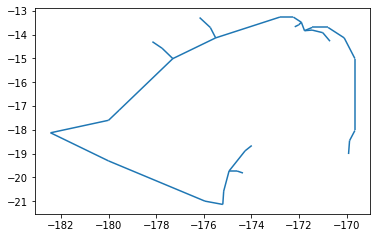

In [107]:
pacific_cable_gps = gdf[(gdf['cable_id'].isin(pacific_landingPoint['cable_id'])) & (gdf['lon1'] < -168)]
print(pacific_cable_gps.shape)
temp_gpf = gpd.GeoDataFrame([
[-182.43744782858172, -18.123638259082412, -179.999798,-19.305384,LineString([[-182.43744782858172, -18.123638259082412], [-179.999798,-19.305384]])],
[-182.43744782858172, -18.123638259082412, -179.999798,-17.597999,LineString([[-182.43744782858172, -18.123638259082412], [-179.999798,-17.597999]])]],columns=['lon1','lat1','lon2','lat2','geometry'],geometry='geometry')
temp_gpf['fr_id'] = round((round(temp_gpf['lon1'],5) + round(temp_gpf['lat1'],5))*100000,0)
temp_gpf['to_id'] = round((round(temp_gpf['lon2'],5) + round(temp_gpf['lat2'],5))*100000,0)
pacific_cable_gps = pacific_cable_gps.append(temp_gpf)
pacific_cable_gps.plot()

In [108]:
chinese_postman_lines = gpd.GeoDataFrame([
# [-175.20000165073517,-21.13346565929308,Point(-175.20000165073517,-21.13346565929308), -174.3521422513667,-19.81379624685283,Point(-174.3521422513667,-19.81379624685283)],
[-173.98368505307081,-18.65921570866675,Point(-173.98368505307081,-18.65921570866675), -170.6957048416213,-14.276544564158712,Point(-170.6957048416213,-14.276544564158712)],
[-169.91670539347172,-19.016714981418488,Point(-169.91670539347172,-19.016714981418488), -174.3521422513667,-19.81379624685283,Point(-174.3521422513667,-19.81379624685283)],
[-171.76669408292253,-13.833489255757883,Point(-171.76669408292253,-13.833489255757883), -172.17816102513325,-13.670594022635811,Point(-172.17816102513325,-13.670594022635811)],
[-178.1581082284118,-14.29683787673278,Point(-178.1581082284118,-14.29683787673278), -176.17500034981677,-13.28200057514735,Point(-176.17500034981677,-13.28200057514735)]],columns=['lon1','lat1','geometry_a', 'lon2','lat2','geometry_b'])
chinese_postman_lines['fr_id'] = round((round(chinese_postman_lines['lon1'],5) + round(chinese_postman_lines['lat1'],5))*100000,0)
chinese_postman_lines['to_id'] = round((round(chinese_postman_lines['lon2'],5) + round(chinese_postman_lines['lat2'],5))*100000,0)


<AxesSubplot:>

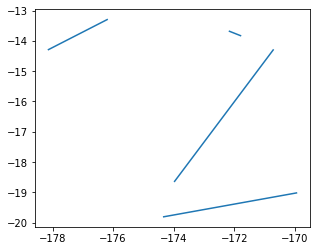

In [109]:
chinese_postman_lines['line'] = chinese_postman_lines.apply(lambda x: LineString([x['geometry_a'], x['geometry_b']]), axis=1)
target_gdf = gpd.GeoDataFrame(chinese_postman_lines, geometry=chinese_postman_lines['line'])
target_gdf['fr_point'] = gpd.points_from_xy(x=target_gdf['lon1'],y=target_gdf['lat1'])
target_gdf['to_point'] = gpd.points_from_xy(x=target_gdf['lon2'],y=target_gdf['lat2'])
target_gdf['distance_from_previous'] = target_gdf['fr_point'].distance(target_gdf['to_point'])
target_gdf['length_from_previous'] = target_gdf['distance_from_previous'] * 103.3934 + 51.6973
target_gdf.plot()

In [110]:
def chinese_postman():
    chinese_postman_lines['line'] = chinese_postman_lines.apply(lambda x: LineString([x['geometry_a'], x['geometry_b']]), axis=1)
    target_gdf = gpd.GeoDataFrame(chinese_postman_lines, geometry=chinese_postman_lines['line'])
    return target_gdf
chinese_postman_gdf = chinese_postman()

In [111]:
pacific_cable_gps.head(5)

index        lon1       lat1 cable_id  cable_length  cable_capacity  \
630  703.0 -169.874805 -18.453814  manatua        3634.0            10.0   
631  704.0 -169.916705 -19.016715  manatua        3634.0            10.0   
632  706.0 -171.449804 -13.698987  manatua        3634.0            10.0   
633  707.0 -170.774805 -13.698987  manatua        3634.0            10.0   
634  708.0 -170.099805 -14.135775  manatua        3634.0            10.0   

     cable_cost        lon2       lat2                      fr_point  \
630       100.0 -169.649806 -18.026426  POINT (-169.87481 -18.45381)   
631       100.0 -169.874805 -18.453814  POINT (-169.91671 -19.01671)   
632       100.0 -171.766694 -13.833489  POINT (-171.44980 -13.69899)   
633       100.0 -171.449804 -13.698987  POINT (-170.77480 -13.69899)   
634       100.0 -170.774805 -13.698987  POINT (-170.09981 -14.13578)   

                         to_point       fr_id       to_id  \
630  POINT (-169.64981 -18.02643) -18832862.0 -18767624.0   
631  POINT (-169.87481 -18.45381) -18893342.0 -18832862.0   
632  POINT (-171.76669 -13.83349) -18514879.0 -18560018.0   
633  POINT (-171.44980 -13.69899) -18447379.0 -18514879.0   
634  POINT (-170.77480 -13.69899) -18423559.0 -18447379.0   

     distance_from_previous  total_distance  length_from_previous  \
630                0.482996       32.680099             53.708730   
631                0.564458       32.680099             62.767316   
632                0.344253       32.680099             38.280614   
633                0.675000       32.680099             75.059388   
634                0.803995       32.680099             89.403596   

                                                  line  \
630  LINESTRING (-169.87480542315404 -18.4538137757...   
631  LINESTRING (-169.91670539347172 -19.0167149814...   
632  LINESTRING (-171.44980430741003 -13.6989872696...   
633  LINESTRING (-170.77480478558613 -13.6989872696...   
634  LINESTRING (-170.0998052637621 -14.13577537506...   

                                              geometry  
630  LINESTRING (-169.87481 -18.45381, -169.64981 -...  
631  LINESTRING (-169.91671 -19.01671, -169.87481 -...  
632  LINESTRING (-171.44980 -13.69899, -171.76669 -...  
633  LINESTRING (-170.77480 -13.69899, -171.44980 -...  
634  LINESTRING (-170.09981 -14.13578, -170.77480 -...

In [112]:
world_basemap = gpd.read_file('../../Dataset/GIS_data/worldMap_detailed.geojson')
world_basemap

FID                               COUNTRY ISO          COUNTRYAFF  \
0      1                        American Samoa  AS       United States   
1      2  United States Minor Outlying Islands  UM       United States   
2      3                          Cook Islands  CK         New Zealand   
3      4                      French Polynesia  PF              France   
4      5                                  Niue  NU         New Zealand   
..   ...                                   ...  ..                 ...   
244  245              Northern Mariana Islands  MP       United States   
245  246                                 Palau  PW               Palau   
246  247                    Russian Federation  RU  Russian Federation   
247  248                                 Spain  ES               Spain   
248  249                              Canarias  ES               Spain   

    AFF_ISO   SHAPE_Leng   SHAPE_Area  \
0        US     0.600124     0.013720   
1        US     0.480216     0.003216   
2        NZ     0.980664     0.013073   
3        FR     3.930211     0.175332   
4        NZ     0.541413     0.021414   
..      ...          ...          ...   
244      US     0.908853     0.019927   
245      PW     1.105323     0.031136   
246      RU  1536.287150  2931.526082   
247      ES    51.724956    52.915449   
248      ES     9.491474     0.695336   

                                              geometry  
0    MULTIPOLYGON (((-170.74390 -14.37555, -170.749...  
1    MULTIPOLYGON (((-160.02114 -0.39805, -160.0281...  
2    MULTIPOLYGON (((-159.74698 -21.25667, -159.793...  
3    MULTIPOLYGON (((-149.17920 -17.87084, -149.258...  
4    MULTIPOLYGON (((-169.89389 -19.14556, -169.930...  
..                                                 ...  
244  MULTIPOLYGON (((145.73468 15.08722, 145.72830 ...  
245  MULTIPOLYGON (((134.53137 7.35444, 134.52234 7...  
246  MULTIPOLYGON (((-179.99999 68.98010, -179.9580...  
247  MULTIPOLYGON (((-2.91472 35.27361, -2.93924 35...  
248  MULTIPOLYGON (((-17.91125 27.77374, -17.96389 ...  

[249 rows x 8 columns]

In [113]:
worldMap = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
worldMap.loc[worldMap['name'] == 'France', 'iso_a3'] = 'FRA'
worldMap.loc[worldMap['name'] == 'Norway', 'iso_a3'] = 'NOR'
worldMap.loc[worldMap['name'] == 'N. Cyprus', 'iso_a3'] = 'CYP'
worldMap.loc[worldMap['name'] == 'Somaliland', 'iso_a3'] = 'SOM'
worldMap.loc[worldMap['name'] == 'Kosovo', 'iso_a3'] = 'RKS'
worldMap

pop_est      continent                      name iso_a3  gdp_md_est  \
0       920938        Oceania                      Fiji    FJI      8374.0   
1     53950935         Africa                  Tanzania    TZA    150600.0   
2       603253         Africa                 W. Sahara    ESH       906.5   
3     35623680  North America                    Canada    CAN   1674000.0   
4    326625791  North America  United States of America    USA  18560000.0   
..         ...            ...                       ...    ...         ...   
172    7111024         Europe                    Serbia    SRB    101800.0   
173     642550         Europe                Montenegro    MNE     10610.0   
174    1895250         Europe                    Kosovo    RKS     18490.0   
175    1218208  North America       Trinidad and Tobago    TTO     43570.0   
176   13026129         Africa                  S. Sudan    SSD     20880.0   

                                              geometry  
0    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1    POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2    POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3    MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4    MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  
..                                                 ...  
172  POLYGON ((18.82982 45.90887, 18.82984 45.90888...  
173  POLYGON ((20.07070 42.58863, 19.80161 42.50009...  
174  POLYGON ((20.59025 41.85541, 20.52295 42.21787...  
175  POLYGON ((-61.68000 10.76000, -61.10500 10.890...  
176  POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...  

[177 rows x 6 columns]

(-22.0, -12.0)

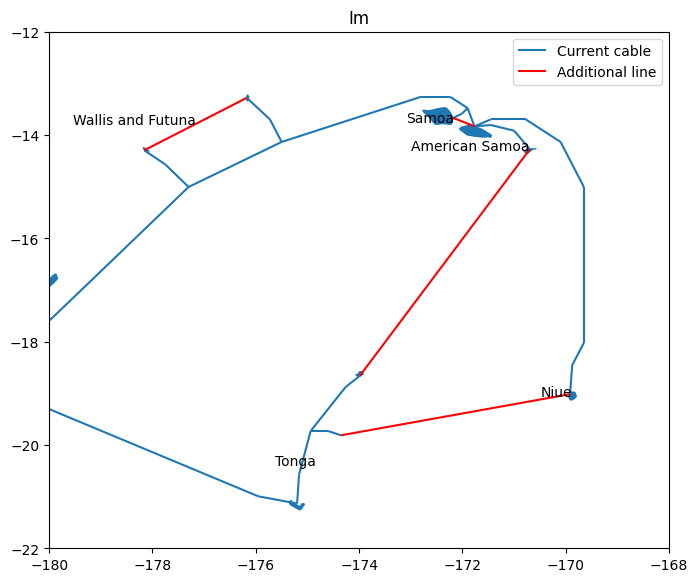

In [114]:
fig     = plt.figure(figsize=(8,8),dpi = 100)
ax      = plt.subplot(111)
world_basemap.plot(ax=ax)
# ax.annotate(world_basemap['COUNTRY'], xy=(x, y), xytext=(3, 3), textcoords="offset points")

world_basemap.apply(lambda x: ax.annotate(text=x['COUNTRY'], xy=x.geometry.centroid.coords[0], ha='right'), axis=1)


pacific_cable_gps.plot(ax=ax,label = 'Current cable')
chinese_postman_gdf.plot(ax=ax,color='r',label = 'Additional line')
plt.legend()
plt.title("Im")
plt.xlim([-180,-168])
plt.ylim([-22,-12])


In [115]:
G3 = nx.from_pandas_edgelist(pacific_cable_gps, 'fr_id', 'to_id', edge_attr=['index', 'length_from_previous','cable_capacity','cable_cost'], create_using=nx.Graph)

print(np.average(list(nx.algorithms.degree_centrality(G3).values())))

G4 = nx.from_pandas_edgelist(pacific_cable_gps.append(chinese_postman_gdf), 'fr_id', 'to_id', edge_attr=['index', 'length_from_previous','cable_capacity','cable_cost'], create_using=nx.Graph)
print(np.average(list(nx.algorithms.degree_centrality(G4).values())))

# chinese_postman_gdf.plot()
# pacific_cable_gps.plot()
print('universally all the node is more participate into the network')

0.058823529411764705
0.0659536541889483
universally all the node is more participate into the network


0.2740740740740741, 0.26595365418894834
The improved network is less dependent on the high degree nodes


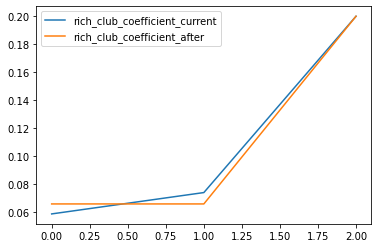

In [116]:
dict_rickClub_current = nx.algorithms.rich_club_coefficient(G3,normalized=False)
dict_rickClub_after = nx.algorithms.rich_club_coefficient(G4,normalized=False)
df_rickClub = pd.DataFrame(dict_rickClub_current.values(),columns=['rich_club_coefficient_current'])
df_rickClub['rich_club_coefficient_after'] = dict_rickClub_after.values()
df_rickClub.plot()


print(f'{sum(list(dict_rickClub_current.values())[-2:])}, {sum(list(dict_rickClub_after.values())[-2:])}')
# print(dict_rickClub_current)
# print(dict_rickClub_after)
print('The improved network is less dependent on the high degree nodes')

In [117]:
list(dict_rickClub_current.values())[-2:]

[0.07407407407407407, 0.2]

In [118]:
temp = pacific_cable_gps

raw_centrality = temp[temp['fr_id'].isin(max(nx.connected_components(G3), key=len))]
raw_centrality['centrality'] = raw_centrality['fr_id'].map(nx.degree_centrality(G3))


world_map = folium.Map(location=[-17,-175], tiles="OpenStreetMap", zoom_start=6)

country_centrality=list(raw_centrality["centrality"]*100)
lon=list(raw_centrality["lon1"])
lat=list(raw_centrality["lat1"])
num=raw_centrality.shape[0]
for i in range(num):
    folium.CircleMarker(radius=float(country_centrality[i]),location=[lat[i],lon[i]],color="crimson",fill=True,fill_color="crimson",fill_opacity=0.7).add_to(world_map)
world_map

In [119]:
temp = pacific_cable_gps.append(chinese_postman_gdf)

raw_centrality = temp[temp['fr_id'].isin(max(nx.connected_components(G4), key=len))]
raw_centrality['centrality'] = raw_centrality['fr_id'].map(nx.degree_centrality(G4))


world_map = folium.Map(location=[-17,-175], tiles="OpenStreetMap", zoom_start=6)

country_centrality=list(raw_centrality["centrality"]*100)
lon=list(raw_centrality["lon1"])
lat=list(raw_centrality["lat1"])
num=raw_centrality.shape[0]
for i in range(num):
    folium.CircleMarker(radius=float(country_centrality[i]),location=[lat[i],lon[i]],color="crimson",fill=True,fill_color="crimson",fill_opacity=0.7).add_to(world_map)
world_map

In [120]:
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# world



In [121]:

{k:v for k, v in nx.algorithms.bipartite.node_redundancy(G4).items() if v>0}
# nx.draw_networkx_edges(G4, pos=nx.circular_layout(G4))

# for x in (nx.connected_components(G4)):
#     print(len(x))


# max(nx.connected_components(G4), key=len)

{-18560018.0: 0.16666666666666666,
 -18538009.0: 0.3333333333333333,
 -18560196.0: 1.0,
 -18584875.0: 1.0}

(-22.0, -12.0)

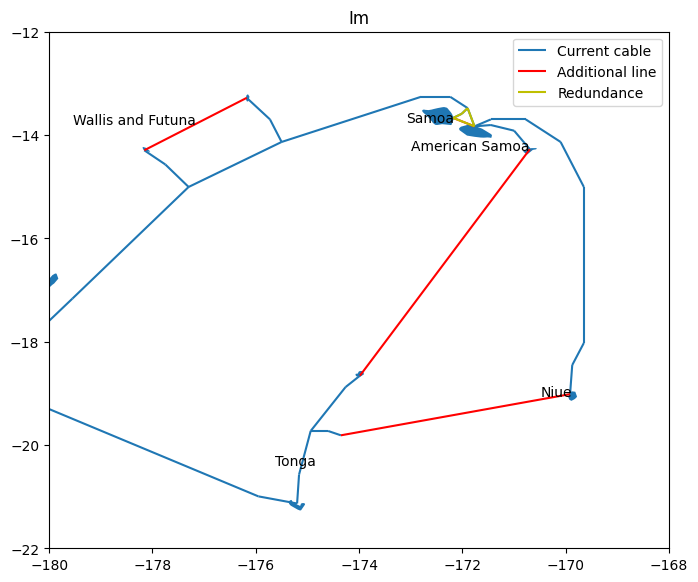

In [122]:
temp = pacific_cable_gps.append(chinese_postman_gdf)


fig     = plt.figure(figsize=(8,8),dpi = 100)
ax      = plt.subplot(111)
world_basemap.plot(ax=ax)
# ax.annotate(world_basemap['COUNTRY'], xy=(x, y), xytext=(3, 3), textcoords="offset points")
world_basemap.apply(lambda x: ax.annotate(text=x['COUNTRY'], xy=x.geometry.centroid.coords[0], ha='right'), axis=1)

pacific_cable_gps.plot(ax=ax,label = 'Current cable')

chinese_postman_gdf.plot(ax=ax,color='r',label = 'Additional line')
temp[temp['fr_id'].isin({k:v for k, v in nx.algorithms.bipartite.node_redundancy(G4).items() if v>0}.keys())].plot(ax=ax,label = 'Redundance', color='y')
plt.legend()
plt.title("Im")
plt.xlim([-180,-168])
plt.ylim([-22,-12])

In [123]:
pacific_cable_groupBy = pacific_landingPoint.groupby(['cable_id','cable_length','cable_cost'],as_index=False).agg({'cable_name':'count'})
sm.OLS(endog=pacific_cable_groupBy['cable_cost'], exog=sm.add_constant(pacific_cable_groupBy['cable_length'])).fit().summary()

/opt/homebrew/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             cable_cost   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     78.96
Date:                Thu, 12 May 2022   Prob (F-statistic):             0.0124
Time:                        15:22:08   Log-Likelihood:                -12.776
No. Observations:                   4   AIC:                             29.55
Df Residuals:                       2   BIC:                             28.32
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.6446      6.217     -0.586      0.617     -30.393      23.104
cable_length     0.0274      0.003      8.886      0.012       0.014       0.041
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.244
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.929
Skew:                          -1.130   Prob(JB):                        0.629
Kurtosis:                       2.316   Cond. No.                     3.01e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [124]:
pacific_cable_groupBy

cable_id  cable_length  cable_cost  cable_name
0                              manatua          3634      100.00           1
1             samoa-american-samoa-sas           250        6.25           2
2  tonga-domestic-cable-extension-tdce           410       10.50           3
3                            tui-samoa          1693       32.50           6

Text(0.5, 1.0, 'Estimation of cable cost')

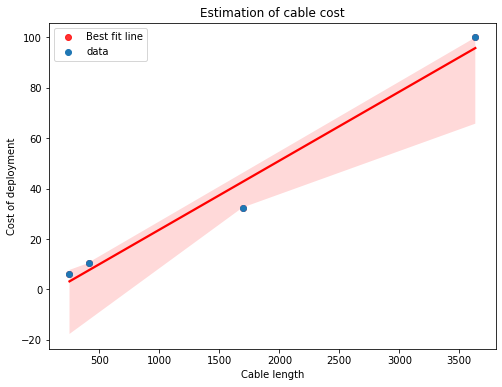

In [125]:
fig, ax = plt.subplots(figsize=(8,6))
sns.regplot(x='cable_length',y='cable_cost',data=pacific_cable_groupBy, fit_reg=True, color = 'r',label='Best fit line') 
plt.scatter(y= pacific_cable_groupBy['cable_cost'], x= pacific_cable_groupBy['cable_length'], label='data')
plt.ylabel('Cost of deployment')  
plt.xlabel('Cable length')  
ax.legend(loc='best')
plt.title("Estimation of cable cost")

In [126]:
chinese_postman_gdf['cable_cost'] = round(chinese_postman_gdf['length_from_previous'] * 0.0274 -3.6446,2)
chinese_postman_gdf = chinese_postman_gdf[chinese_postman_gdf['cable_cost'] > 5]

(-22.0, -14.0)

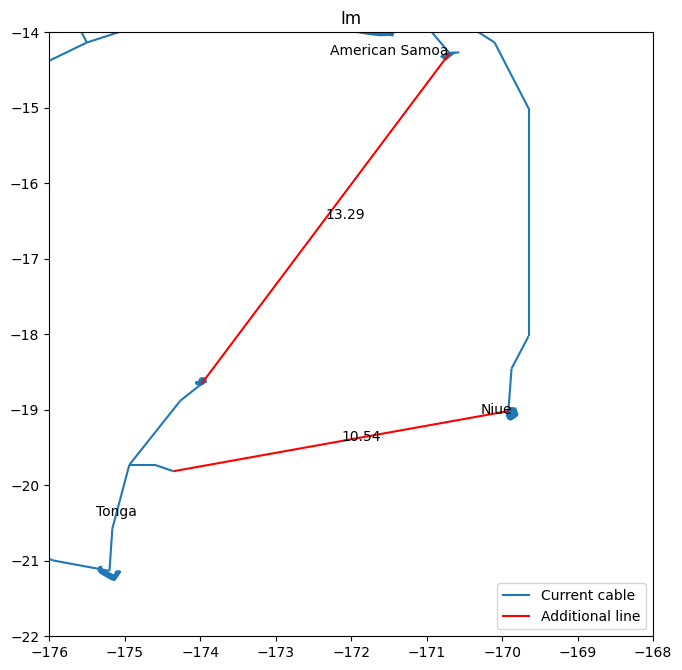

In [127]:
fig     = plt.figure(figsize=(8,8),dpi = 100)
ax      = plt.subplot(111)
world_basemap.plot(ax=ax)
# ax.annotate(world_basemap['COUNTRY'], xy=(x, y), xytext=(3, 3), textcoords="offset points")
world_basemap.apply(lambda x: ax.annotate(text=x['COUNTRY'], xy=x.geometry.centroid.coords[0], ha='right'), axis=1)

pacific_cable_gps.plot(ax=ax,label = 'Current cable')

chinese_postman_gdf.plot(ax=ax,color='r',label = 'Additional line')
chinese_postman_gdf.apply(lambda x: ax.annotate(text=x['cable_cost'], xy=x.geometry.centroid.coords[0], ha='left'), axis=1)
plt.legend(loc='lower right')
plt.title("Im")
plt.xlim([-176,-168])
plt.ylim([-22,-14])

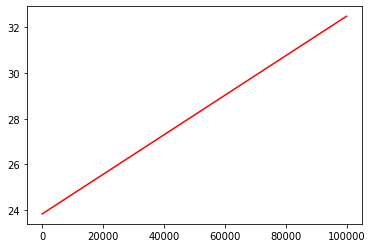

In [128]:
x = np.linspace(0,100000,50)
y = 0.00008654*x+23.83
plt.plot(x, y, '-r', label='y=2x+1')

/var/folders/93/98m4gg790h36hw_xcd31b1d40000gn/T/ipykernel_72357/36457513.py:4: RuntimeWarning: divide by zero encountered in true_divide
  y1 = 23830000/25/12/x+86.54


Text(0, 0.5, 'Monthly cost')

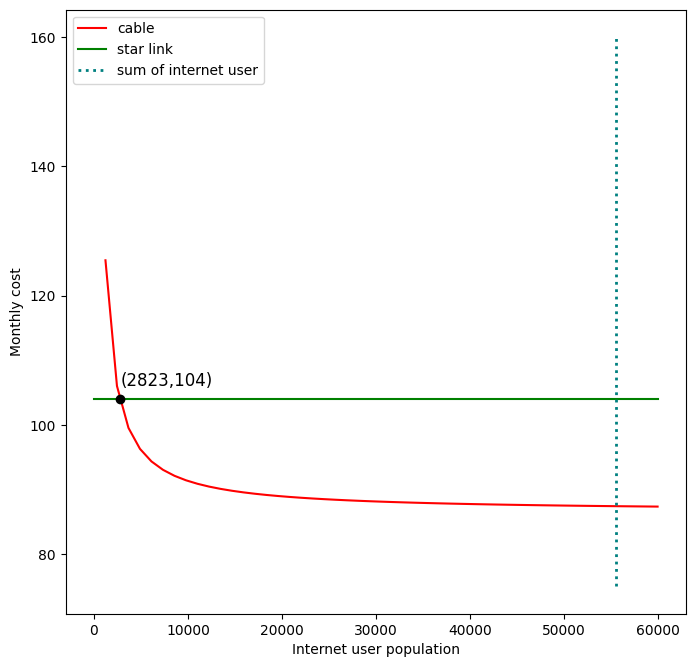

In [129]:
fig     = plt.figure(figsize=(8,8),dpi = 100)
ax      = plt.subplot(111)
x1 = np.linspace(0,60000,50)
y1 = 23830000/25/12/x+86.54
ax.plot(x1, y1, '-r', label='cable')

x2 = np.linspace(0,60000,50)
y2 = 599/10/12+99+x*0
ax.plot(x2, y2, '-g', label='star link')

ax.vlines(x=55612, ymin=75, ymax=160, colors='teal', ls=':', lw=2, label='sum of internet user')

f1 = interp1d(x1, y1, kind = 'linear')
f2 = interp1d(x2, y2, kind = 'linear')
xx = np.linspace(max(x1[0], x2[0]), min(x1[-1], x2[-1]), 1000)

y1_interp = f1(xx)
y2_interp = f2(xx)

idx = np.argwhere(np.diff(np.sign(y1_interp - y2_interp))).flatten()

for index in idx:
    ax.plot(xx[index], y1_interp[index], marker = 'o', markerfacecolor = 'black', markeredgecolor = 'black')

plt.text(round(xx[index],0), round(y1_interp[index]+2,0), f'({round(xx[index],0):.0f},{round(y1_interp[index],0):.0f})', fontsize = 12)


plt.legend(loc='upper left')
plt.xlabel('Internet user population')
plt.ylabel('Monthly cost')

In [130]:
# xx[index]
y1_interp[index]

104.02063418974531